In [45]:
import numpy as np
from qutip import *
from qutip.qip.operations import rx
import scipy as sp
from scipy.optimize import curve_fit,fsolve
from scipy.special import erfc,erf
import os
import sys
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from qutip.qip.operations import ry
from scipy.optimize import curve_fit
import math as ma
from qutip.qip.operations import rz
#[run all cells serialwise. If you want to run selectively, atleast rerun all cells under the specific figure label]

In [46]:
#qubit operators
g=basis(2,0)
e=basis(2,1)
px=(g+e).unit()
mx=(g-e).unit()
py=(g+1j*e).unit()
my=(g-1j*e).unit()


Fig. 2a and Fig. 14 [Performance of GCR]

In [121]:
#These simulations were done in the units of the paper with Ncav=400 for oscillator operators
Ncav = 400
aOp = destroy(Ncav)
aOp1=aOp.dag()
i=2
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i
alpha=6
state=((-2j*alpha*pOp).expm())*basis(Ncav,0)
print("In these units displacement by amplitude 2j displaces vacuum to a coherent state |j>",expect(xOp,state)/alpha)
print(expect(xOp,coherent(Ncav,alpha))/alpha)

In these units displacement by amplitude 2j displaces vacuum to a coherent state |j> 1.0000000000000038
1.0000000000000038


In [122]:
theta=-np.pi/2#change to np.pi for BB1(180)
fail_prob=[]
succ_fid=[]
reset_fid=[]
alph=[]
alph1=[]
chi1=[]
qub_state=rx(theta)*g
for alpha1 in range(40,200):
    alpha=alpha1/20
    chi=-theta/2/alpha
    Opx=tensor(1j*chi*xOp,sigmax()).expm()
    Opy=tensor(1j*chi*pOp,sigmay()).expm()
    state=(Opx*Opy*tensor(coherent(Ncav,alpha),g)).unit()#final state
    state2=tensor(coherent(Ncav,alpha),qub_state).unit()#desired state
    state3=(tensor(qeye(Ncav),ket2dm(qub_state))*state).unit()#state after success
    fail_prob.append(1-expect(tensor(qeye(Ncav),ket2dm(qub_state)),state))#failure probability
    succ_fid.append(1-np.abs(state3.overlap(state2))**2)#success fidelity
    reset_fid.append(1-np.abs(state.overlap(state2))**2)#reset fidelity
    alph.append(alpha)
    chi1.append(chi)

In [123]:
##BB1 protocol generalization to accommodate gaussian functions:
alph_b=[]
chi_b=[]
def sigma(phi):#only xy plane
    return np.cos(phi)*sigmax()+np.sin(phi)*sigmay()
def sigma_xyz(theta,phi):#whole bloch sphere
    return (np.cos(theta)*sigmaz()+np.sin(theta)*sigma(phi))
def rot_xy(theta,phi):
    return (-1j*theta/2*(np.cos(phi)*sigmax()+np.sin(phi)*sigmay())).expm()
def vec_f(vec_i,rot):#qubit vector
    return rot*vec_i*rot.dag()
def rot(phi, theta):
    return (-1j*theta/2*(np.cos(phi)*tensor(sigmax(),qeye(Ncav))+np.sin(phi)*tensor(sigmay(),qeye(Ncav)))).expm()
fail_b=[]
succ_b=[]
reset_b=[]
Delta=1#results should get better with decreasing Delta
r=-np.log(Delta)
sy=[]
phi0=0
phi1=np.arccos(-theta/(4*np.pi))
ep=Delta**2
sfid=[]
ep=0
qub_state=rx(-theta)*g
for alpha1 in range(40,200):
    alpha=alpha1/20
    initial=(displace(Ncav,alpha)*(squeeze(Ncav,r)*basis(Ncav,0)).unit()).unit()
    x=np.abs(expect(xOp,initial))
    beta=theta/x
    state=tensor(g,initial)
    vecf=vec_f(sigma_xyz(0,0),rot_xy(0,0))
    vec=1j*sigma(phi0)*vecf
    Op1=tensor(sigma(phi0),1j*beta/2*(xOp)).expm()*tensor(vec,1j*beta/2*(ep*pOp)).expm()
    state=(Op1*state).unit()
    vecf=vec_f(vecf,rot_xy(np.pi/2,phi0))
    vec=1j*sigma(phi1)*vecf
    Op2=tensor(sigma(phi1),1j/2*np.pi/x*(xOp)).expm()*tensor(vec,1j/2*np.pi/x*(ep*pOp)).expm()
    state=(Op2*state).unit()
    vecf=vec_f(vecf,rot_xy(2*np.pi,phi1))
    vec=1j*sigma(3*phi1)*vecf
    Op3=tensor(sigma(3*phi1),2j/2*np.pi/x*(xOp)).expm()*tensor(vec,2j/2*np.pi/x*(ep*pOp)).expm()
    state=(Op3*state).unit()
    vecf=vec_f(vecf,rot_xy(4*np.pi,3*phi1))
    vec=-1j*sigma(phi1)*vecf
    Op4=tensor(sigma(phi1),1j/2*np.pi/x*(xOp)).expm()*tensor(vec,1j/2*np.pi/x*(ep*pOp)).expm()
    state=(Op4*state).unit()
    state2=tensor(qub_state,coherent(Ncav,alpha))#desired state
    state3=(tensor(ket2dm(qub_state),qeye(Ncav))*state).unit()#state after success
    fail_b.append(1-expect(tensor(ket2dm(qub_state),qeye(Ncav)),state))#failure probability
    succ_b.append(1-np.abs(state3.overlap(state2))**2)#success fidelity
    reset_b.append(1-np.abs(state.overlap(state2))**2)#reset fidelity
    chi_b.append(-theta/2/alpha)
    alph_b.append(alpha)
if theta==-np.pi:
    np.savez("Paper_Data/fail_prob_pi.npz",fail_prob)
    np.savez("Paper_Data/alph_pi.npz",alph)
    np.savez("Paper_Data/succ_fid_pi.npz",succ_fid)
    np.savez("Paper_Data/succ_b_pi.npz",succ_b)
    np.savez("Paper_Data/reset_fid_pi.npz",reset_fid)
    np.savez("Paper_Data/reset_b_pi.npz",reset_b)
    np.savez("Paper_Data/fail_b_pi.npz",fail_b)
    np.savez("Paper_Data/alph_b_pi.npz",alph_b)
    np.savez("Paper_Data/chi_b_pi.npz",chi_b)
    np.savez("Paper_Data/chi1_pi.npz",chi1)
if theta==-np.pi/2:
    np.savez("Paper_Data/fail_prob.npz",fail_prob)
    np.savez("Paper_Data/alph.npz",alph)
    np.savez("Paper_Data/succ_fid.npz",succ_fid)
    np.savez("Paper_Data/succ_b.npz",succ_b)
    np.savez("Paper_Data/reset_fid.npz",reset_fid)
    np.savez("Paper_Data/reset_b.npz",reset_b)
    np.savez("Paper_Data/fail_b.npz",fail_b)
    np.savez("Paper_Data/alph_b.npz",alph_b)
    np.savez("Paper_Data/chi_b.npz",chi_b)
    np.savez("Paper_Data/chi1.npz",chi1)

Fig. 2b (right)

In [89]:
fail_prob=[]
succ_fid=[]
reset_fid=[]
alph=[]
beta=5
for alpha1 in range(40,200):
    alpha=alpha1/20
    chi=np.pi/4/beta
    Rot=tensor(qeye(Ncav),ry(2*alpha*np.pi/4/beta))
    Opx=tensor(1j*chi*xOp,sigmax()).expm()
    Opy=tensor(1j*chi*pOp,sigmay()).expm()
    state=(Opx*Opy*Rot*tensor(coherent(Ncav,beta+1j*alpha),g)).unit()#final state
    state2=tensor(coherent(Ncav,beta+1j*alpha),py)#desired state
    state3=(tensor(qeye(Ncav),ket2dm(py))*state).unit()#state after success
    fail_prob.append(1-expect(tensor(qeye(Ncav),ket2dm(py)),state))#failure probability
    succ_fid.append(1-np.abs(state3.overlap(state2))**2)#success fidelity
    reset_fid.append(1-np.abs(state.overlap(state2))**2)#reset fidelity
    alph.append(alpha)
np.savez("Paper_Data/fail_prob_pa.npz",fail_prob)
np.savez("Paper_Data/succ_fid_pa.npz",succ_fid)
np.savez("Paper_Data/reset_fid_pa.npz",reset_fid)


Fig 2b (left)

In [90]:
fail_prob=[]
succ_fid=[]
reset_fid=[]
alph=[]
chi1=[]
beta=5
for alpha1 in range(40,200):
    alpha=alpha1/20
    chi=np.pi/4/alpha
    Rot=tensor(qeye(Ncav),ry(2*beta*np.pi/4/alpha))
    Opx=tensor(1j*chi*xOp,sigmax()).expm()
    Opy=tensor(1j*chi*pOp,sigmay()).expm()
    state=(Opx*Opy*Rot*tensor(coherent(Ncav,alpha+1j*beta),g)).unit()#final state
    state2=tensor(coherent(Ncav,alpha+1j*beta),py)#desired state
    state3=(tensor(qeye(Ncav),ket2dm(py))*state).unit()#state after success
    fail_prob.append(1-expect(tensor(qeye(Ncav),ket2dm(py)),state))#failure probability
    succ_fid.append(1-np.abs(state3.overlap(state2))**2)#success fidelity
    reset_fid.append(1-np.abs(state.overlap(state2))**2)#reset fidelity
    alph.append(alpha)
    chi1.append(chi)
np.savez("Paper_Data/fail_prob_p.npz",fail_prob)
np.savez("Paper_Data/alph_p.npz",alph)
np.savez("Paper_Data/chi1_p.npz",chi1)
np.savez("Paper_Data/succ_fid_p.npz",succ_fid)
np.savez("Paper_Data/reset_fid_p.npz",reset_fid)


Fig. 3 [BB1(GCR)]

In [91]:
#These simulations were done in the following units
i=np.sqrt(2)
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i
g=basis(2,0)
e=basis(2,1)

In [ ]:
##adjoint BB1(90) protocol generalization to accommodate Gaussian functions:
def sigma(phi):#only xy plane
    return np.cos(phi)*sigmax()+np.sin(phi)*sigmay()
def sigma_xyz(theta,phi):#whole bloch sphere
    return (np.cos(theta)*sigmaz()+np.sin(theta)*sigma(phi))
def rot_xy(theta,phi):
    return (-1j*theta/2*(np.cos(phi)*sigmax()+np.sin(phi)*sigmay())).expm()
def vec_f(vec_i,rot):#qubit vector
    return rot*vec_i*rot.dag()

Delta=0.34#0.8 gives best results
r=-np.log(Delta)
N=200
a=-np.sqrt(np.pi)/2
alph=np.linspace(-2*np.sqrt(np.pi),2*np.sqrt(np.pi),N)
theta=np.pi/2
sy=[]
phi0=0
phi1=np.arccos(-theta/(4*np.pi))
ep=Delta**2
sfid=[]
sfid1=[]
sy1=[]
x=np.pi/theta
beta=(theta/2/(np.sqrt(np.pi)/2))

def GCR_BB1(initial):
    state=tensor(initial,g)
    
    vecf=vec_f(sigma_xyz(0,0),rot_xy(0,0))
    vec=1j*sigma(phi1)*vecf
    Op4=tensor(-1j*x*beta*(xOp),sigma(phi1)).expm()*tensor(-1j*x*beta*(ep*pOp),vec*vecf).expm()
    state=(Op4*state).unit()
    
    vecf=vec_f(vecf,rot_xy(2*np.pi,phi1))#theta-1,phi-1
    vec=1j*sigma(3*phi1)*vecf
    Op3=tensor(-2j*np.sqrt(np.pi)*(xOp),sigma(3*phi1)).expm()*tensor(-2j*np.sqrt(np.pi)*(ep*pOp),vec*vecf).expm()
    state=(Op3*state).unit()
    
    vecf=vec_f(vecf,rot_xy(4*np.pi,3*phi1))#theta-1,phi-1
    vec=1j*sigma(phi1)*vecf
    Op2=tensor(-1j*np.sqrt(np.pi)*(xOp),sigma(phi1)).expm()*tensor(-1j*np.sqrt(np.pi)*(ep*pOp),vec*vecf).expm()
    state=(Op2*state).unit()
    
    vecf=vec_f(vecf,rot_xy(2*np.pi,phi1))#theta-1,phi-1
    vec=1j*sigma(phi0)*vecf
    Op1=tensor(-1j*beta*(xOp),sigma(phi0)).expm()*tensor(-1j*beta*(ep*pOp),vec).expm()
    state=(Op1*state).unit()
    return state
    
def BB1(initial):
    state=tensor(initial,g)
    
    Op4=tensor(1j*np.sqrt(np.pi)*(xOp),sigma(phi1)).expm()
    state=(Op4.dag()*state).unit()
    
    Op3=tensor(2j*np.sqrt(np.pi)*(xOp),sigma(3*phi1)).expm()
    state=(Op3.dag()*state).unit()
    
    Op2=tensor(1j*np.sqrt(np.pi)*(xOp),sigma(phi1)).expm()
    state=(Op2.dag()*state).unit()
    
    Op1=tensor(1j*beta*(xOp),sigma(phi0)).expm()
    state=(Op1.dag()*state).unit()
    return state

    
for alpha1 in alph:
    alpha=alpha1+a
    initial=(displace(Ncav,alpha/np.sqrt(2))*(squeeze(Ncav,r)*basis(Ncav,0)).unit()).unit()

    state=GCR_BB1(initial)
    sy.append(np.abs(expect(ket2dm(py),state.ptrace(1))))
    sfid.append(1-fidelity(ket2dm(initial),state.ptrace(0)))

    state=BB1(initial)
    sy1.append(np.abs(expect(ket2dm(py),state.ptrace(1))))
    sfid1.append(1-fidelity(ket2dm(initial),state.ptrace(0)))
np.savez("Paper_Data/GCR_BB1_alpha.npz",sy)
np.savez("Paper_Data/BB1_alpha.npz",sy1)
np.savez("Paper_Data/GCR_BB1_alpha_fid.npz",sfid)
np.savez("Paper_Data/BB1_alpha_fid.npz",sfid1)
np.savez("Paper_Data/GCR_BB1_err.npz",alph/np.sqrt(np.pi))

/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/scipy/sparse/_base.py:1008: SparseEfficiencyWarning: Constructing a DIA matrix with 399 diagonals is inefficient
  return self.tocoo(copy=copy).todia(copy=False)


Fig. 4c [Squeezing vs fidelity]

1.3191314843337603


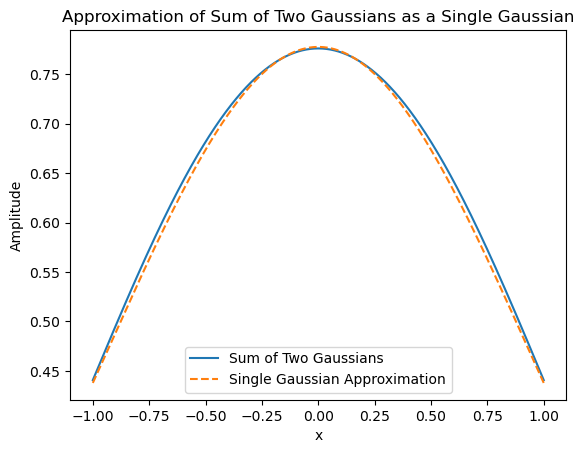

Approximated width of the single Gaussian: 1.3191314843337603


In [124]:
#sum of two Gaussians can approximate a single Gaussian for small widths (basis of squeezing gadget)
def gaussian(x, mu, sigma):
    return np.exp(-((x - mu) / sigma) ** 2)*(2/np.pi/sigma**2)**(1/4)

def sum_of_gaussians(x, alpha, Delta):
    norm=np.sqrt(2)*np.sqrt(1+np.exp(-2*alpha**2/Delta**2))
    return (gaussian(x, alpha, Delta) + gaussian(x, -alpha, Delta))/norm

def approximate_single_gaussian_width(alpha, Delta):
    # Generate x values
    x = np.linspace(-1, 1, 1000)
    
    # Calculate the sum of two Gaussians
    sum_gaussian = sum_of_gaussians(x, alpha, Delta)
    
    # Fit the sum of Gaussians to a single Gaussian
    popt, _ = curve_fit(lambda x, sigma: gaussian(x,0,sigma), x, sum_gaussian, p0=[Delta])
    
    # The optimized width of the single Gaussian
    approx_width = popt[0]
    
    return approx_width
# Parameters
alpha = 0.5
Delta = 1

# Approximate the width of the single Gaussian
approx_width = approximate_single_gaussian_width(alpha, Delta)
print(approx_width)

# Generate x values for plotting
x = np.linspace(-1, 1, 1000)

# Calculate the sum of two Gaussians
sum_gaussian = sum_of_gaussians(x, alpha, Delta)

# Calculate the single Gaussian with the approximated width
single_gaussian = gaussian(x, 0, approx_width)

# Plot the results
plt.plot(x, sum_gaussian, label='Sum of Two Gaussians')
plt.plot(x, single_gaussian, label='Single Gaussian Approximation', linestyle='--')
plt.legend()
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.title('Approximation of Sum of Two Gaussians as a Single Gaussian')
plt.show()

print(f"Approximated width of the single Gaussian: {approx_width}")

In [125]:
#These simulations were done in the units of the paper but with Ncav=100
Ncav = 100
aOp = destroy(Ncav)
aOp1=aOp.dag()
i=2
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i

In [ ]:
#Ncav changed to 100
def disp(alpha,sx):
    return tensor(2j*np.imag(alpha)*xOp-2j*np.real(alpha)*pOp,sx).expm()
def squeeze_(state,y,b,Delta):#accelerated
    #state=(disp(1j*y/4/Delta,sigmay())*disp(y,sigmax()))*state #non-accelerated sequence!
    state=(disp(1j*b,sigmay())*disp(y,sigmax()))*state
    return state.unit()

s1=[]
f=[]
for a in [0.06,0.13,0.27]:
    bn=[0.03,0.02,0.01,0.01,0.01,0.01,0.01,0.01]#small corrections for maximum unentanglement of the qubit without any decrease in fidelity
    #these corrections are not optimized formally because protocol used for 4d is the formal (fast) protocol
    for c in np.linspace(-2,0,10):
        s=0
        i=-1
        squeeze_p=0 
        state=tensor(basis(Ncav,0),g)
        while np.abs(squeeze_p)<=11.2:
            i=i+1
            if i<-1:#post-selection not activated
                state1=(tensor(qeye(Ncav),ket2dm(g))*state).unit()
            else:
                state1=state
            x=variance(xOp,state1.ptrace(0))
            p=variance(pOp,state1.ptrace(0))
            squeeze_p=-10*np.log10(4*p)
            squeeze_x=-10*np.log10(4*x)
            sz=expect(sigmaz(),state.ptrace(1))
            r=np.log(4*p)/2
            state_sq=squeeze(Ncav,r)*basis(Ncav,0)
            m=a*(4*x)**(c/2)#a*(Delta^c), 4x=Delta^2
            if i<len(bn):
                b=bn[i]
            else:
                b=0
            state=squeeze_(state1,m,m/4/x-b,x)     
            s=s+2*(m+m/4/x-b)
        s1.append(s)
        state_sq=squeeze(Ncav,r)*basis(Ncav,0)
        f.append(fidelity(tensor(state_sq,g),(state)))
np.savez("Paper_Data/squeeze_time.npz",s1)
np.savez("Paper_Data/squeeze_fidelity.npz",f)

Fig. 4d-e, Fig. 15 [Squeezing vs time]

In [126]:
#These simulations were done in the following units with Ncav=100
i=np.sqrt(2)
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i
unit=1
#The CD time for plotting has been changed accordingly!

In [127]:
def disp(alpha,sx):
    return tensor(unit*1j*np.real(alpha)*xOp-unit*1j*np.imag(alpha)*pOp,sx).expm()

def squeeze_(state,y,Delta):#accelerated
    state=(disp(-1j*Delta,sigmay())*disp(y,sigmax()))*state
    return state.unit()

state=tensor(basis(Ncav,0),g)
sz2=[]
p1=[]
x1=[]
s=0
k=1/2/np.sqrt(2)
s1=[]
m=[0]
pn=[]
f=[]#fisher info
N=14#14
b=[]
b=[0,0.025,0.05,0.04,0.014,-0.008,-0.0085,0.017,0.028,0.0064,0.01,0.05,0.028,0.06]+[0]*(N-(len(b)))
ps=1
#0.028 onwards it looks like it has different dependence
#these corrections were optimized formally by fitting the sigmay/sigmax curve (depening on your choice of basis) against a linear function to extract the exact slope that needs to be cancelled. 
for i in range(N):
    if ps==1:#post-selection not activated (change the sign to save files for post-selection)
        state1=(tensor(qeye(Ncav),ket2dm(g))*state).unit()
    else:
        state1=state
    x=variance(xOp,state1.ptrace(0))
    p=variance(pOp,state1.ptrace(0))
    r=np.log(unit*2*p)/2
    squeeze_p=-10*np.log10(unit*2*p)
    squeeze_x=-10*np.log10(unit*2*x)
    sz=expect(sigmaz(),state.ptrace(1))
    p1.append(20*np.log10(np.exp(r)))
    x1.append(20*np.log10(np.exp(np.log(unit*2*x)/2)))
    s1.append(s)  
    pn.append(p)
    f.append(2/x)
    sz2.append(sz)
    if i==0:
        sz1=sz
        i1=i
    elif sz<sz1:
        sz1=sz
        i1=i
    if p<=1:
        c=0
    else:
        c=1
    bn=b[i]
    a=k*np.power(p,c)
    state=squeeze_(state1,a,a/p/unit/2-bn/unit)     
    s=s+a+a/p/unit/2-bn/unit+48*10**(-3)#time added for two-rotations
    m.append(a/p)
p1.append(20*np.log10(np.exp(r)))
x1.append(20*np.log10(np.exp(np.log(unit*2*x)/2)))
s1.append(s)  
pn.append(p)
f.append(2/x)
sz2.append(sz)
x=variance(xOp,state.ptrace(0))
p=variance(pOp,state.ptrace(0))
squeeze_p=-10*np.log10(unit*2*p)
squeeze_x=-10*np.log10(unit*2*x)
sz=expect(sigmaz(),state.ptrace(1))

if ps==0:
    np.savez("Paper_Data/squeeze_x.npz",x1[:-1])
    np.savez("Paper_Data/squeeze_p.npz",p1[:-1])
    np.savez("Paper_Data/time.npz",s1[:-1])
    np.savez("Paper_Data/fisher_info.npz",f[:-1])
else:
    np.savez("Paper_Data/squeeze_x_ps.npz",x1[:-1])
    np.savez("Paper_Data/squeeze_p_ps.npz",p1[:-1])
    np.savez("Paper_Data/time_ps.npz",s1[:-1])
    np.savez("Paper_Data/fisher_info_ps.npz",f[:-1])



In [128]:
#These simulations were done in the units of the paper (only to verify if predictions from the previous cell hold) with Ncav=100
i=2
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i

In [ ]:
def disp(alpha,sx):
    return tensor(2j*np.real(alpha)*xOp-2j*np.imag(alpha)*pOp,sx).expm()

def squeeze_(state,y,Delta):#accelerated
    state=(disp(-1j*Delta,sigmay())*disp(y,sigmax()))*state
    return state.unit()

state=tensor(basis(Ncav,0),g)
sz2=[]
p1=[]
x1=[]
s=0
k=1/2/np.sqrt(2)
s1=[]
m=[0]
pn=[]
f=[]#fisher info
N=16
b=[]
b=[0,0.025,0.05,0.04,0.014,-0.008,-0.0085,0.017,0.028,0.0064,0.01,0.05,0.028,0.06]+[0]*(N-(len(b)))#b for x=0.99 and c=0 or 0.99
   
for i in range(N):
    if i<-1:#post-selection not activated
        state1=(tensor(qeye(Ncav),ket2dm(g))*state).unit()
    else:
        state1=state
    x=variance(xOp,state1.ptrace(0))
    p=variance(pOp,state1.ptrace(0))
    r=np.log(unit*2*p)/2
    squeeze_p=-10*np.log10(4*p)
    squeeze_x=-10*np.log10(4*x)
    sz=expect(sigmaz(),state.ptrace(1))
    p1.append(20*np.log10(np.exp(r)))
    x1.append(20*np.log10(np.exp(np.log(4*x)/2)))
    s1.append(s)  
    pn.append(p)
    f.append(2/x)
    sz2.append(sz)
    if i==0:
        sz1=sz
        i1=i
    elif sz<sz1:
        sz1=sz
        i1=i
    if p<=1:
        c=0
    else:
        c=1
    bn=b[i]
    a=k*np.power(p,c)
    state=squeeze_(state1,a,a/p/4-bn/2)      
    s=s+a+a/p/4-bn/2+48*10**(-3)#two-rotations
p1.append(20*np.log10(np.exp(r)))
x1.append(20*np.log10(np.exp(np.log(4*x)/2)))
s1.append(s)  
pn.append(p)
f.append(2/x)
sz2.append(sz)
x=variance(xOp,state.ptrace(0))
p=variance(pOp,state.ptrace(0))
squeeze_p=-10*np.log10(4*p)
squeeze_x=-10*np.log10(4*x)
sz=expect(sigmaz(),state.ptrace(1))

r=np.log(4*p)/2
state1=squeeze(Ncav,r)*basis(Ncav,0)
print('squeezing in dB:',squeeze_p,squeeze_x,(1+sz)/2,s)#matches Alec's definition with 20 log10(e^|r|)

#Extract the right squeezing in dB for comaprison
#state2=(tensor(qeye(Ncav),ket2dm(g))*state).unit()
print('infidelity',1-(ket2dm(state1)*(state.ptrace(0))).tr())
state1=tensor(state1,g).unit()
print('hybrid infidelity',1-np.abs(state1.overlap(state))**2)

squeezing in dB: -10.98220702118718 9.85692787891017 0.9990061679772213 9.365101567970807
infidelity (0.007135595768782421+0j)
hybrid infidelity 0.0071355957687839755


Fig. 5c [Cat state prep]

In [100]:
#These simulations were done in the units of the paper with Ncav=400
Ncav = 400
aOp = destroy(Ncav)
aOp1=aOp.dag()
i=2
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i

In [ ]:
initial=basis(Ncav,0)
succ=[]
succ_fid=[]
res=[]
alph=np.linspace(2,10,100)
for alpha in alph:
    cat_state=(coherent(Ncav,alpha)+coherent(Ncav,-alpha)).unit()
    state=(tensor(initial,g)).unit()
    alpha1=np.pi/4/alpha
    Opz=tensor(2j*alpha*pOp,sigmax()).expm()
    Opx=tensor(-1j*alpha1*xOp,sigmay()).expm()
    Opy=tensor(1j*alpha1*pOp,sigmax()).expm()
    state1=(Opy*Opx*Opz*state).unit()#unentanglement!
    state10=((tensor(qeye(Ncav),ket2dm(g))*state1).unit()).ptrace(0).unit()
    state0=(state1.ptrace(0).unit())
    state_qub=state1.ptrace(1).unit()
    succ.append(1-expect(ket2dm(g),state_qub))
    res.append(1-np.abs(state0.overlap(cat_state))**2)#reset
    succ_fid.append(1-np.abs(state10.overlap(cat_state))**2)#post-select
np.savez("Paper_Data/fail_prob_cat_I.npz",succ)
np.savez("Paper_Data/alph_cat_I.npz",alph)
np.savez("Paper_Data/succ_fid_cat_I.npz",succ_fid)
np.savez("Paper_Data/reset_fid_cat_I.npz",res)

In [ ]:

##BB1(90) protocol generalization to accommodate gaussian functions:
alph_b=[]
chi_b=[]
def sigma(phi):#only xy plane
    return np.cos(phi)*sigmax()+np.sin(phi)*sigmay()
def sigma_xyz(theta,phi):#whole bloch sphere
    return (np.cos(theta)*sigmaz()+np.sin(theta)*sigma(phi))
def rot_xy(theta,phi):
    return (-1j*theta/2*(np.cos(phi)*sigmax()+np.sin(phi)*sigmay())).expm()
def vec_f(vec_i,rot):#qubit vector
    return rot*vec_i*rot.dag()
def rot(phi, theta):
    return (-1j*theta/2*(np.cos(phi)*tensor(sigmax(),qeye(Ncav))+np.sin(phi)*tensor(sigmay(),qeye(Ncav)))).expm()
succ=[]
succ_fid=[]
res=[]
Delta=1#results should get better with decreasing Delta
r=-np.log(Delta)
theta=-np.pi/2
sy=[]
phi0=0
phi1=np.arccos(-theta/(4*np.pi))
ep=Delta**2
sfid=[]
ep=0
state=(tensor(initial,g)).unit()
alph=np.linspace(2,10,100)
for alpha in alph:
    cat_state=(coherent(Ncav,alpha)-coherent(Ncav,-alpha)).unit()
    x=alpha
    beta=theta/x
    state=tensor(g,basis(Ncav,0))
    Opz=tensor(sigmay(),2j*alpha*pOp).expm()
    state=(Opz*state).unit()
    vecf=vec_f(sigma_xyz(0,0),rot_xy(0,0))
    vec=1j*sigma(phi0)*vecf
    Op1=tensor(sigma(phi0),1j*beta/2*(xOp)).expm()*tensor(vec,1j*beta/2*(ep*pOp)).expm()
    state=(Op1*state).unit()
    vecf=vec_f(vecf,rot_xy(np.pi/2,phi0))#theta-1,phi-1
    vec=1j*sigma(phi1)*vecf
    Op2=tensor(sigma(phi1),1j/2*np.pi/x*(xOp)).expm()*tensor(vec,1j/2*np.pi/x*(ep*pOp)).expm()
    state=(Op2*state).unit()
    vecf=vec_f(vecf,rot_xy(2*np.pi,phi1))#theta-1,phi-1
    vec=1j*sigma(3*phi1)*vecf
    Op3=tensor(sigma(3*phi1),2j/2*np.pi/x*(xOp)).expm()*tensor(vec,2j/2*np.pi/x*(ep*pOp)).expm()
    state=(Op3*state).unit()
    vecf=vec_f(vecf,rot_xy(4*np.pi,3*phi1))#theta-1,phi-1
    vec=-1j*sigma(phi1)*vecf
    Op4=tensor(sigma(phi1),1j/2*np.pi/x*(xOp)).expm()*tensor(vec,1j/2*np.pi/x*(ep*pOp)).expm()
    state=(Op4*state).unit()
    state2=tensor(e,cat_state)#desired state
    state3=(tensor(ket2dm(e),qeye(Ncav))*state).unit()#state after success
    succ.append(1-expect(tensor(ket2dm(e),qeye(Ncav)),state))#failure probability
    succ_fid.append(1-np.abs(state3.overlap(state2))**2)#success fidelity
    res.append(1-np.abs(state.overlap(state2))**2)#reset fidelity
np.savez("Paper_Data/fail_prob_catb.npz",succ)
np.savez("Paper_Data/alph_catb.npz",alph)
np.savez("Paper_Data/succ_fid_catb.npz",succ_fid)
np.savez("Paper_Data/reset_fid_catb.npz",res)



In [103]:

initial=basis(Ncav,0)
succ=[]
succ_fid=[]
res=[]
alph=np.linspace(2,10,100)
for alpha in alph:
    cat_state=(coherent(Ncav,alpha)+coherent(Ncav,-alpha)).unit()
    state=(tensor(initial,g)).unit()
    alpha1=np.pi/4/alpha
    Opz=tensor(2j*alpha*pOp,sigmax()).expm()
    Opx=tensor(-1j*alpha1*xOp,sigmay()).expm()
    Opy=tensor(1j*alpha1*pOp,sigmax()).expm()
    state1=(Opx*Opz*state).unit()#unentanglement!
    state10=((tensor(qeye(Ncav),ket2dm(g))*state1).unit()).ptrace(0).unit()
    state0=(state1.ptrace(0).unit())
    state_qub=state1.ptrace(1).unit()
    succ.append(1-expect(ket2dm(g),state_qub))
    res.append(1-np.abs(state0.overlap(cat_state))**2)#reset
    succ_fid.append(1-np.abs(state10.overlap(cat_state))**2)#post-select
np.savez("Paper_Data/fail_prob_cat.npz",succ)
np.savez("Paper_Data/alph_cat.npz",alph)
np.savez("Paper_Data/succ_fid_cat.npz",succ_fid)
np.savez("Paper_Data/reset_fid_cat.npz",res)



Fig. 7 [Four-legged cat state prep]

In [104]:
#These simulations were done in the units of the paper with Ncav=400
Ncav = 400
aOp = destroy(Ncav)
aOp1=aOp.dag()
i=np.sqrt(2)
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i


In [105]:
def rot(phi, theta):
    return (-1j*theta/2*(np.cos(phi)*sigmax()+np.sin(phi)*sigmay())).expm()

def rot_error(theta,phi1,phi2):
    return rot(phi1,2*theta)*rot(phi2,4*theta)*rot(phi1,2*theta)*rot(0,theta)

def rot_error_90(epsilon):
    return rot_error(np.pi/2+epsilon,0.54*np.pi,1.61944*np.pi)

Rx11=tensor(qeye(Ncav),rot(0,np.pi/2))
Rx1=tensor(qeye(Ncav),rot(0,-np.pi/2))
Rx21=tensor(qeye(Ncav),rot(0.54*np.pi,np.pi/2))
Rx2=tensor(qeye(Ncav),rot(0.54*np.pi,-np.pi/2))
Rx31=tensor(qeye(Ncav),rot(1.61944*np.pi,np.pi/2))
Rx3=tensor(qeye(Ncav),rot(1.61944*np.pi,-np.pi/2))
Rx41=tensor(qeye(Ncav),rot(0.54*np.pi,np.pi/2))
Rx4=tensor(qeye(Ncav),rot(0.54*np.pi,-np.pi/2))

def BB1(measState,alpha):
    epsilon=np.pi/4/alpha
    Hamx1=tensor(epsilon*xOp,sigmaz())
    Hamx2=tensor(2*epsilon*xOp,sigmaz())
    Hamx3=tensor(4*epsilon*xOp,sigmaz())
    Hamx4=tensor(2*epsilon*xOp,sigmaz())
    measState=Rx11*measState*Rx11.dag()
    measState=mesolve(Hamx1,measState,[0,1],c_ops=[]).states[-1]
    measState=Rx1*measState*Rx1.dag()
    measState=Rx21*measState*Rx21.dag()
    measState=mesolve(Hamx2,measState,[0,1],c_ops=[]).states[-1]
    measState=Rx2*measState*Rx2.dag()
    measState=Rx31*measState*Rx31.dag()
    measState=mesolve(Hamx3,measState,[0,1],c_ops=[]).states[-1]
    measState=Rx3*measState*Rx3.dag()
    measState=Rx41*measState*Rx41.dag()
    measState=mesolve(Hamx4,measState,[0,1],c_ops=[]).states[-1]
    measState=Rx4*measState*Rx4.dag()
    return measState


In [106]:
#asymmetric 4 cats
def cat4(alpha):
    beta=2*alpha
    state=((displace(Ncav,-1j*beta/np.sqrt(2))+displace(Ncav,1j*beta/np.sqrt(2)))*basis(Ncav,0)).unit()
    Opy=tensor(1j*alpha*pOp,sigmaz()).expm()#splits into four
    log_finite=(Opy*tensor(state,px)).unit()  
    log_finite=BB1(ket2dm(log_finite),alpha)
    c=np.exp(1j*alpha*beta/2)
    state=ket2dm((((1/c)*displace(Ncav,alpha/np.sqrt(2)+1j*beta/np.sqrt(2))
                +(c)*displace(Ncav,alpha/np.sqrt(2)-1j*beta/np.sqrt(2))
                -(c)*displace(Ncav,-alpha/np.sqrt(2)+1j*beta/np.sqrt(2))
                -(1/c)*displace(Ncav,-alpha/np.sqrt(2)-1j*beta/np.sqrt(2)))*basis(Ncav,0)).unit())
    fin_state=tensor(state,ket2dm(mx))
    return 1-expect(ket2dm(mx),log_finite.ptrace(1)), 1-fidelity(log_finite,fin_state)
def cat41(alpha):
    beta=2*alpha
    state=((displace(Ncav,-1j*beta/np.sqrt(2))+displace(Ncav,1j*beta/np.sqrt(2)))*basis(Ncav,0)).unit()
    Opy=tensor(1j*alpha*pOp,sigmax()).expm()#splits into four
    Opx1=tensor(-1j*np.pi/4/alpha*xOp,sigmay()).expm()#unentangles in one direction $p=0$, should act as correction for the other
    log_finite=(Opx1*Opy*tensor(state,g)).unit()  
    c=np.exp(1j*alpha*beta/2)
    state=ket2dm((((1/c)*displace(Ncav,alpha/np.sqrt(2)+1j*beta/np.sqrt(2))
                +(c)*displace(Ncav,alpha/np.sqrt(2)-1j*beta/np.sqrt(2))
                +(c)*displace(Ncav,-alpha/np.sqrt(2)+1j*beta/np.sqrt(2))
                +(1/c)*displace(Ncav,-alpha/np.sqrt(2)-1j*beta/np.sqrt(2)))*basis(Ncav,0)).unit())
    fin_state=tensor(state,ket2dm(g))
    return 1-expect(ket2dm(g),log_finite.ptrace(1)), 1-fidelity(log_finite,fin_state)
def cat42(alpha):
    beta=2*alpha
    state=((displace(Ncav,-1j*beta/np.sqrt(2))+displace(Ncav,1j*beta/np.sqrt(2)))*basis(Ncav,0)).unit()
    Opy=tensor(1j*alpha*pOp,sigmax()).expm()#splits into four
    Opx1=tensor(1j*np.pi/4/alpha*xOp,sigmay()).expm()#unentangles in one direction $p=0$, should act as correction for the other
    Opy1=tensor(1j*np.pi/4/alpha*pOp,sigmax()).expm()#unentangles in $x=0$, should act as correction for the other
    log_finite=ket2dm((Opy1*Opx1*Opy*tensor(state,g)).unit())#ngcr
    c=np.exp(1j*alpha*beta/2)
    state=ket2dm((((1/c)*displace(Ncav,alpha/np.sqrt(2)+1j*beta/np.sqrt(2))
                -(c)*displace(Ncav,alpha/np.sqrt(2)-1j*beta/np.sqrt(2))
                -(c)*displace(Ncav,-alpha/np.sqrt(2)+1j*beta/np.sqrt(2))
                +(1/c)*displace(Ncav,-alpha/np.sqrt(2)-1j*beta/np.sqrt(2)))*basis(Ncav,0)).unit())
    fin_state=tensor(state,ket2dm(g))
    return 1-expect(ket2dm(g),log_finite.ptrace(1)), 1-fidelity(log_finite,fin_state)
fid4=[]
fid41=[]
fid42=[]
alph=np.linspace(2,7,100)
for alpha in alph:
    fid4.append(cat4(alpha))
    fid41.append(cat41(alpha))
    fid42.append(cat42(alpha))
np.savez("Paper_Data/4_cat_asym_b.npz",fid4)
np.savez("Paper_Data/4_cat_asym.npz",fid41)
np.savez("Paper_Data/4_cat_asym_gcr.npz",fid42)

In [107]:
#symmetric 4 cats
def cat4(alpha):
    state=((displace(Ncav,-1j*alpha/np.sqrt(2))+displace(Ncav,1j*alpha/np.sqrt(2)))*basis(Ncav,0)).unit()
    Opy=tensor(1j*alpha*pOp,sigmaz()).expm()#splits into four
    log_finite=(Opy*tensor(state,px)).unit()  
    log_finite=BB1(ket2dm(log_finite),alpha)
    c=np.exp(1j*alpha**2/2)
    state=ket2dm((((1/c)*displace(Ncav,alpha/np.sqrt(2)+1j*alpha/np.sqrt(2))
                +(c)*displace(Ncav,alpha/np.sqrt(2)-1j*alpha/np.sqrt(2))
                -(c)*displace(Ncav,-alpha/np.sqrt(2)+1j*alpha/np.sqrt(2))
                -(1/c)*displace(Ncav,-alpha/np.sqrt(2)-1j*alpha/np.sqrt(2)))*basis(Ncav,0)).unit())
    fin_state=tensor(state,ket2dm(mx))
    return 1-expect(ket2dm(mx),log_finite.ptrace(1)), 1-fidelity(log_finite,fin_state)
def cat41(alpha):
    state=((displace(Ncav,-1j*alpha/np.sqrt(2))+displace(Ncav,1j*alpha/np.sqrt(2)))*basis(Ncav,0)).unit()
    Opy=tensor(1j*alpha*pOp,sigmax()).expm()#splits into four
    Opx1=tensor(-1j*np.pi/4/alpha*xOp,sigmay()).expm()#unentangles in one direction $p=0$, should act as correction for the other
    log_finite=(Opx1*Opy*tensor(state,g)).unit()  
    c=np.exp(1j*alpha**2/2)
    state=ket2dm((((1/c)*displace(Ncav,alpha/np.sqrt(2)+1j*alpha/np.sqrt(2))
                +(c)*displace(Ncav,alpha/np.sqrt(2)-1j*alpha/np.sqrt(2))
                +(c)*displace(Ncav,-alpha/np.sqrt(2)+1j*alpha/np.sqrt(2))
                +(1/c)*displace(Ncav,-alpha/np.sqrt(2)-1j*alpha/np.sqrt(2)))*basis(Ncav,0)).unit())
    fin_state=tensor(state,ket2dm(g))
    return 1-expect(ket2dm(g),log_finite.ptrace(1)), 1-fidelity(log_finite,fin_state)
fid4=[]
fid41=[]
alph=np.linspace(2,7,100)
for alpha in alph:
    fid4.append(cat4(alpha))
    fid41.append(cat41(alpha))
np.savez("Paper_Data/4_cat_sym_b.npz",fid4)
np.savez("Paper_Data/4_cat_sym.npz",fid41)


Fig. 6 [GKP state prep]

In [129]:
#These simulations were done in the units of the paper with Ncav=400
Ncav = 400#we have verified that Ncav=400 yields the same answer for GCR
aOp = destroy(Ncav)
aOp1=aOp.dag()
i=2
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i
meas_g=tensor(qeye(Ncav),ket2dm(g))


Noiseless GKP preparation for Sec. IV C

predicted N and Delta according to our expression (to be derived in this cell) 7 0.2
fidelity between the gaussian and binomial functions 0.9946068234471408
Optimal N for Delta = 0.3981071705534972 is 2.0085335198181204 with N*Delta^2 (formula dervied here) = 0.31833111023896976
Optimal N for Delta = 0.35481338923357547 is 2.5285938885405304 with N*Delta^2 (formula dervied here) = 0.3183311102391102
Optimal N for Delta = 0.31622776601683794 is 3.1833111023910803 with N*Delta^2 (formula dervied here) = 0.31833111023910804
Optimal N for Delta = 0.28183829312644537 is 4.007551240445312 with N*Delta^2 (formula dervied here) = 0.3183311102390029
Optimal N for Delta = 0.251188643150958 is 5.045208095663932 with N*Delta^2 (formula dervied here) = 0.31833111023900873
Optimal N for Delta = 0.22387211385683395 is 6.351540679421501 with N*Delta^2 (formula dervied here) = 0.3183311102390347
Optimal N for Delta = 0.19952623149688797 is 7.996115965369254 with N*Delta^2 (formula dervied here) = 0.318

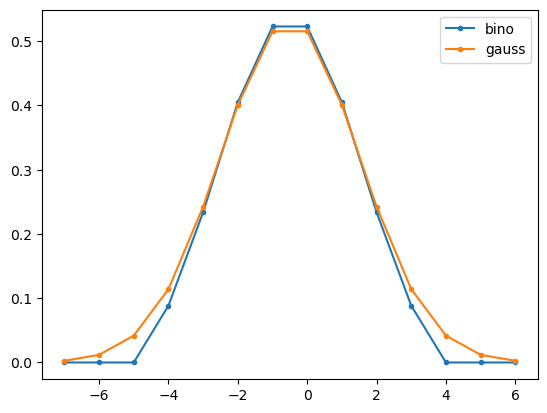

In [130]:
#plotting binomial against Gaussian for N optimized for delta using newton raphson (used to verify the dependence of N on Delta)
Delta=0.2
N=int(np.floor(0.32/Delta**2))
print("predicted N and Delta according to our expression (to be derived in this cell)",N,Delta)
if np.mod(N,2)==0:
    mu=0
else:
    mu=1
mid=N/2
bino1=[]
gauss1=[]
stirling1=[]
k1=[]
overlap=0
norm=0
def bino(k):
    return np.sqrt(sp.special.comb(N,k+mu+np.int64(N/2))/2**N)
def gauss(k):
    return np.exp(-((2*k+mu)*Delta)**2*np.pi/4)
for k in range(-np.int64(Ncav+mu/2),np.int64(Ncav+mu/2)-mu+1):
    norm=norm+gauss(k)**2
for k in range(-np.int64(N+mu/2),np.int64(N+mu/2)-mu+1):
    bino1.append(bino(k))
    gauss1.append(gauss(k)/np.sqrt(norm))
    k1.append(k)
    overlap=overlap+bino1[-1]*gauss1[-1]
plt.plot(k1,bino1,'.-',label='bino')
plt.plot(k1,gauss1,'.-',label='gauss')
plt.legend()
print("fidelity between the gaussian and binomial functions",overlap**2)

#Newton Raphson Method to find optimal N for given Delta
import scipy.optimize as optimize
a=[]
x=[]
y=[]
# Define the equation as a function of a
f=0.490
def equation(a, x):
    return (x**(-x) * (1-x)**(-(1-x)))/2 - np.exp(-2*a*Delta**2*np.pi* (x-0.5)**2)

a_initial_guess = 1
for s in range(8,16):
    Delta=10**(-s/20)
    a_solution = optimize.newton(equation, a_initial_guess, args=(f,))
    x.append(Delta)
    a.append(a_solution)
    y.append(a_solution*Delta**2)
    print("Optimal N for Delta =", Delta, "is", a_solution, "with N*Delta^2 (formula dervied here) =", a_solution*Delta**2)

In [131]:
#functions for various expressions used for GKP states to compare analytical fidelity with the state definitions

def logical(mu,delta,Ncav,normalize=True):#Gaussian version
    psi = 0*basis(Ncav)
    r=-np.log(delta)
    a=np.sqrt(np.pi/2)
    for n in range(-np.int64(Ncav+mu/2),np.int64(Ncav+mu/2)-mu+1):
        psi = (psi+np.exp(-((2*n+mu)*a*delta)**2/2)*displace(Ncav,(2*n+mu)*a)*squeeze(Ncav,r)*basis(Ncav,0))
    if normalize:
        psi = psi/psi.norm()
    return psi

def logical1(mu,delta,N,Ncav,normalize=True):#binomial version
    psi = 0*basis(Ncav)
    r=-np.log(delta)
    a=np.sqrt(np.pi/2)
    for n in range(-np.int64((N+mu)/2),np.int64((N+mu)/2)-mu+1):
        psi = (psi+np.sqrt(sp.special.comb(N,n+mu+np.int64(N/2)))*displace(Ncav,(2*n+mu)*a)*squeeze(Ncav,r)*basis(Ncav,0))
    if normalize:
        psi = psi/psi.norm()
    return psi

Fig. 6c

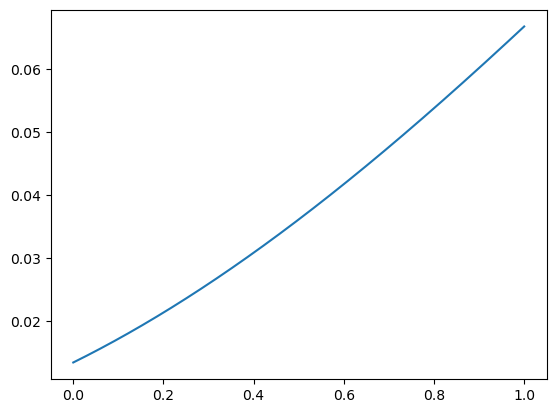

In [132]:
#angles optimized for after the third step of qubit unentnglement. To be used for Fig. 6c.
def angle(a,k):#k is the step
    if np.mod(k,2)==0:
        x=k/2+1
    else:
        x=(k+1)/2+1
    tot=np.cos(np.pi/4-a*np.sqrt(np.pi)*x)**2
    tot1=1
    i=0
    while x>=2:
        x=x-2
        i=i+1
        tot=tot+(ma.comb(k,i)*np.cos(a*np.sqrt(np.pi)*np.array(x)))**2
        tot1=tot1+ma.comb(k,i)**2
    return (1-tot/(tot1))
k=3
x1=np.linspace(0,1,1000)
x=np.sqrt(np.pi)/4/k-np.linspace(0,0.1,1000)
y=[angle(x,2)]
plt.plot(x1,y[0])

In [133]:
#circuit for arbitrary Delta
delt=np.linspace(0.24,0.34,10)
time_sq=[20*np.log10(np.exp(-np.log(delta)))*(8/12.395)*np.sqrt(2) for delta in delt]#sqrt(2) multiplied to take care of wigner units
time=[]
GKP_squeeze=[]
GKP_hyb_fidelity=[]
GKP_success=[]
for i,Delta in enumerate(np.linspace(0.24,0.34,10)):
    alpha=np.sqrt(np.pi/2)
    r=-np.log(Delta)
    state=ket2dm(squeeze(Ncav,r)*basis(Ncav,0))
    
    #two blobs
    Opx=tensor(2j*alpha*pOp,sigmax()).expm()
    N1=int(0.32/Delta**2)
    if np.mod(N1,2)==0:
        N1=N1+1
    time_gcr=time_sq[i]
    log_finite1=tensor(state,ket2dm(g))
    for i in range(N1):
        Opy=tensor(-1j*np.pi/4/(i+1)/alpha*xOp,sigmay()).expm()
        Opx1=tensor(1j*np.pi/4/(i+1)/alpha*Delta**2*pOp,sigmax()).expm()
        if i>=2:
            Opx1=tensor(1j*angle(np.pi/4/(i+1),i+1)/alpha*Delta**2*pOp,sigmax()).expm()
        W=Opx1*Opy*Opx
        log_finite1=(W*log_finite1*W.dag()).unit()  
        #state=log_finite1.ptrace(0)
        #print(i,expect(tensor(qeye(Ncav),ket2dm(g)),log_finite1))
        if i<2:
            time_gcr=time_gcr+2*alpha+(np.pi/4/(i+1)/alpha)*(1+Delta**2)
        else:
            time_gcr=time_gcr+2*alpha+angle(np.pi/4/(i+1)/alpha,k)*(Delta**2)+(np.pi/4/(i+1)/alpha)
    log0_finite1=(meas_g*log_finite1*meas_g.dag()).unit()
    state_40=ket2dm(logical1(1,Delta,N1,Ncav))#state0
    state40=tensor(state_40,ket2dm(g))
    print(Delta,N1,time_gcr, 20*np.log10(np.exp(r)))
    time.append(time_gcr)
    GKP_squeeze.append(20*np.log10(np.exp(r)))
    GKP_success.append(expect(meas_g,log_finite1))
    GKP_hyb_fidelity.append(fidelity(state40,log_finite1))
    print("binomial",fidelity(state40,log_finite1),expect(meas_g,log_finite1))
np.savez("Paper_Data/GKP_squeeze.npz",GKP_squeeze)
np.savez("Paper_Data/GKP_success.npz",GKP_success)
np.savez("Paper_Data/GKP_hyb_fidelity.npz",GKP_hyb_fidelity)
np.savez("Paper_Data/GKP_time.npz",time)

alec_delta=[0.175,0.219,0.262,0.306,0.350]
alec_squeeze=[20*np.log10(np.exp(-np.log(delta))) for delta in alec_delta]#this should be divided by 2 when used as duration
print(alec_squeeze)
alec_time_98=[28.703924,24.49195,18.5462,13.213958,10.847128]#F=0.99
alec_time_99=[28.703924,24.49195,18.5462,13.213958,10.847128]#F=0.98
np.savez("Paper_Data/GKP_a_squeeze.npz",alec_squeeze)
np.savez("Paper_Data/GKP_a_time.npz",alec_time_98)
"""
Alec's GKP paramters [obtained from GitHub repo of Eickbusch et al.]
GKP_plus_Z_delta_0.175_F_98.npz
24 28.703924
GKP_plus_Z_delta_0.175_F_99.npz
24 28.703924
GKP_plus_Z_delta_0.219_F_98.npz
19 24.49195
GKP_plus_Z_delta_0.219_F_99.npz
19 24.49195
GKP_plus_Z_delta_0.262_F_98.npz
14 18.5462
GKP_plus_Z_delta_0.262_F_99.npz
14 18.5462
GKP_plus_Z_delta_0.306_F_98.npz
10 13.213958
GKP_plus_Z_delta_0.306_F_99.npz
10 13.213958
GKP_plus_Z_delta_0.350_F_98.npz
8 10.847128
GKP_plus_Z_delta_0.350_F_99.npz
8 10.847128
"""

/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/scipy/sparse/_base.py:1008: SparseEfficiencyWarning: Constructing a DIA matrix with 399 diagonals is inefficient
  return self.tocoo(copy=copy).todia(copy=False)


0.24 5 25.346449359509617 12.39577516576788
binomial 0.9816469656342672 0.9831368281379289
0.2511111111111111 5 24.994091976957147 12.00268140583848
binomial 0.981621302888724 0.9831222481272632
0.26222222222222225 5 24.657563704992505 11.626610129384364
binomial 0.9815934216556084 0.9831067790395657
0.2733333333333333 5 24.335574543814243 11.266148046718916
binomial 0.9815631396045819 0.9830903872077151
0.28444444444444444 3 18.72259764785254 10.920050882549505
binomial 0.9967136250983613 0.9936676493304383
0.29555555555555557 3 18.425682210831205 10.587217456165156
binomial 0.9966947121642008 0.9936651752075023
0.3066666666666667 3 18.140243350629387 10.266668547482142
binomial 0.996673694252727 0.9936623749241904
0.3177777777777778 3 17.865482736291057 9.957529526205636
binomial 0.996650399893762 0.9936592055722674
0.3288888888888889 3 17.60068437324494 9.659015967607726
binomial 0.9966246156663163 0.993655619745736
0.34 3 17.34520365618707 9.370421659154895
binomial 0.9965962467853

"\nAlec's GKP paramters [obtained from GitHub repo of Eickbusch et al.]\nGKP_plus_Z_delta_0.175_F_98.npz\n24 28.703924\nGKP_plus_Z_delta_0.175_F_99.npz\n24 28.703924\nGKP_plus_Z_delta_0.219_F_98.npz\n19 24.49195\nGKP_plus_Z_delta_0.219_F_99.npz\n19 24.49195\nGKP_plus_Z_delta_0.262_F_98.npz\n14 18.5462\nGKP_plus_Z_delta_0.262_F_99.npz\n14 18.5462\nGKP_plus_Z_delta_0.306_F_98.npz\n10 13.213958\nGKP_plus_Z_delta_0.306_F_99.npz\n10 13.213958\nGKP_plus_Z_delta_0.350_F_98.npz\n8 10.847128\nGKP_plus_Z_delta_0.350_F_99.npz\n8 10.847128\n"

Fig. 6b

/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


SBS ancilla qubit purity after 1 steps= 0.5768401478654314
SBS ancilla qubit purity after 11 steps= (0.9784898483098208-1.7922158645219337e-11j)
check which GKP state is the last state after SBS protocol runs for 20 steps


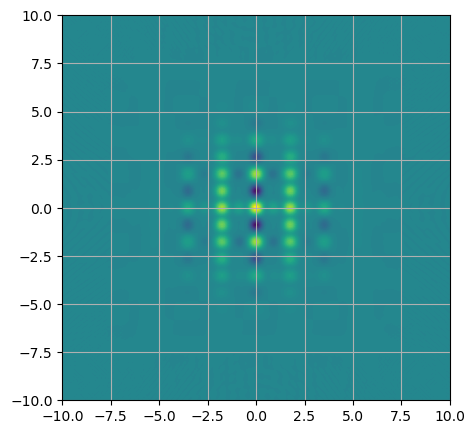

SBS-binomial logical 0 infidelity 0.09412015971418031
SBS-binomial logical 1 infidelity 0.062440091275437815
check if the defs denote correct wigner functions by plotting wigner of analytical logical 0 state


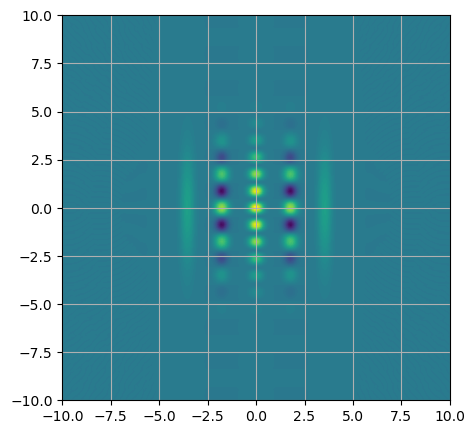

In [134]:
#Preparation Circuit using SBS (for comparison)
Delta=0.34
N=int(np.floor(0.32/Delta**2))#obtained using the newton-raphson calculations done in the previous cell
Mmax = 20
measIndex=Mmax-4
a=2*np.sqrt(np.pi)
a1=a/2
tpi=np.pi
nOp=aOp1*aOp
U=(1j*(np.pi/2)*aOp1*aOp).expm()
U1=U.dag()   
Hamx=tensor(sigmaz(),a1*xOp)
Hamp=tensor(sigmaz(),-a1*pOp)
Id=qeye(Ncav)
Rx=tensor(rx(np.pi/2),qeye(Ncav)) #rotation by pi/2 along x
Rx1=Rx.dag()

DeltaEpsilon=Delta
        
def applyMeasurement(state,correctionDirection,measType='+Z'):
    if 'Z' in measType:
        #displacePauli = displace(Ncav,1j*a/4/np.sqrt(2))
        displacePauli = displace(Ncav,a/4/np.sqrt(2)*np.sinh(DeltaEpsilon**2)+1j*a/4/np.sqrt(2)*np.cosh(DeltaEpsilon**2))#exact Pauli
    elif 'X' in measType:
        displacePauli = displace(Ncav,a/4/np.sqrt(2))
    elif 'Y' in measType:
        displacePauli = displace(Ncav,(1+1j)*a/4/np.sqrt(2))
    displacePaulid = displacePauli.dag()

    if '+' in measType:
        M = 0.5*(displacePauli + displacePaulid)
    elif '-' in measType:
        M = 0.5*(displacePauli - displacePaulid)

    if correctionDirection ==1:
        M = displacePauli*M
    else:
        M = displacePaulid*M
    newState = M*state*M.dag()
    return newState/newState.tr()

def computeTrajCooling(tempState,Mmax):
    s=[0]
    stateList=[tempState]
    for i in range(Mmax):
        tempState,tempqubit  = grid(tempState,ket2dm(px))
        tempState1 ,tempqubit = grid(U*tempState*U1,ket2dm(px))
        tempState=U1*tempState1*U 
        s.append(s[-1]+a*(np.sinh(Delta**2)*np.sqrt(2)+np.cosh(Delta**2)/np.sqrt(2)))
        if i==measIndex:
            tempState=applyMeasurement(tempState,correctionDirection=1)
            tempState=applyMeasurement(tempState,correctionDirection=-1)
            s[-1]=s[-1]+4*(a/4/np.sqrt(2)*np.sinh(DeltaEpsilon**2)+1j*a/4/np.sqrt(2)*np.cosh(DeltaEpsilon**2))
        if np.mod(i,10)==0:
            print("SBS ancilla qubit purity after",i+1,"steps=",(tempqubit**2).tr())
        stateList.append(tempState)
        
    return stateList,s


def grid(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState,[0,np.sinh(Delta**2)/np.sqrt(2)],c_ops=[],options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState*Rx1
    measState=mesolve(Hamp,measState,[0,np.sqrt(2)*np.cosh(Delta**2)],c_ops=[],options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState*Rx
    measState=mesolve(Hamx,measState,[0,np.sinh(Delta**2)/np.sqrt(2)],c_ops=[],options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState,newqubit
state0_List,time_sbs=computeTrajCooling(ket2dm(basis(Ncav,0)),Mmax)
state0=state0_List[-1]#logical state after Mmax steps
state1=state0_List[-2]#logical state after Mmax-1 steps

print("check which GKP state is the last state after SBS protocol runs for", Mmax, "steps")
extent = 10
xvec = np.linspace(-extent,extent,200)
W = wigner(state0,xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X,Y,W,100)
ax.grid(True)
plt.show()

#compare against analytical targets
state_0=ket2dm(logical1(0,Delta,N,Ncav))#binomial GKP logical 0
state_1=ket2dm(logical1(1,Delta,N,Ncav))#binomial GKP logical 1
print("SBS-binomial logical 0 infidelity",1-fidelity(state0,state_1))
print("SBS-binomial logical 1 infidelity",1-fidelity(state1,state_0))

print("check if the defs denote correct wigner functions by plotting wigner of analytical logical 0 state")
extent = 10
xvec = np.linspace(-extent,extent,200)
W = wigner(state_0,xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X,Y,W,100)
ax.grid(True)
plt.show()

squeezing and anti-squeezing of the target Delta: -9.370421659154877 9.370421659155006
after 0 steps of GCR's cat prep circuit, the probability of a g outcome is: 0.9999904744351015
after 1 steps of GCR's cat prep circuit, the probability of a g outcome is: 0.9999927230432564
after 2 steps of GCR's cat prep circuit, the probability of a g outcome is: 0.9937137311607711
total number of steps recording the state and time lists 4 4
state fidelities for un-post-selected and post-selected GCR states against SBS and analytical targets
SBS-GCR fidelity 0.9145030247033781 0.9173910435296107
gaussian-GCR fidelity 0.9886266836661691 0.9917487827131046
binomial-GCR fidelity 0.9966025456364339 0.9997498243729823
fidelities of the various states in comparison of GCR against each other
gauss-bin 0.9921300996300285
sbs-gauss 0.9284192293287152
sbs-bin 0.9171228548930134


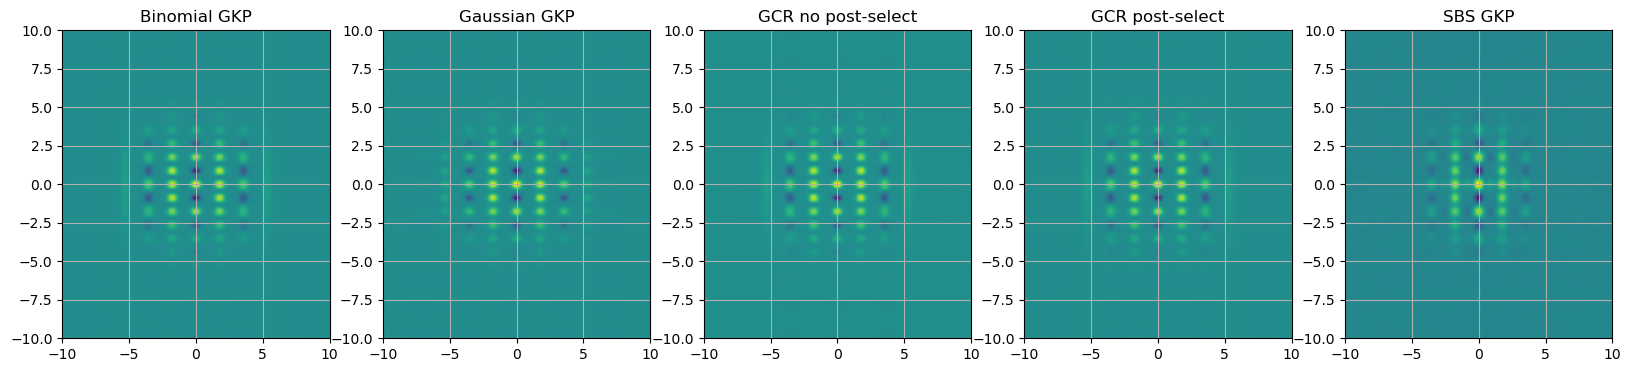

In [135]:
#New circuit using GCR
alpha=np.sqrt(np.pi/2)

#Squeezed state initialization
r=-np.log(Delta)
state=ket2dm(squeeze(Ncav,r)*basis(Ncav,0))
p=variance(pOp,state)
x=variance(xOp,state)
print("squeezing and anti-squeezing of the target Delta:",-10*np.log10(4*p),-10*np.log10(4*x))

#two peaks 
Opx=tensor(2j*alpha*pOp,sigmax()).expm()
N1=3
time_gcr=[10.45]#time required to prepare initial squeezed state from Sec. IVA extracted from figure 4d 
log_List=[state]
for i in range(N1):
    Opy=tensor(-1j*np.pi/4/(i+1)/alpha*xOp,sigmay()).expm()
    Opx1=tensor(1j*np.pi/4/(i+1)/alpha*Delta**2*pOp,sigmax()).expm()
    W=Opx1*Opy*Opx
    log_finite1=(W*tensor(state,ket2dm(g))*W.dag()).unit()  
    state=log_finite1.ptrace(0)# no post selection before the next round!
    print("after",i, "steps of GCR's cat prep circuit, the probability of a g outcome is:",expect(tensor(qeye(Ncav),ket2dm(g)),log_finite1))
    time_gcr.append(time_gcr[-1]+2*alpha+(np.pi/4/(i+1)/alpha)*(1+Delta**2))#total time taken
    log_List.append(state)#no post selection state added to the list
log0_finite1=(meas_g*log_finite1*meas_g.dag()).unit()#state post-selected on g outcome for comparison 
state_30=ket2dm(logical(1,Delta,Ncav))#Gaussian definition
state=log0_finite1.ptrace(0)
state_40=ket2dm(logical1(1,Delta,N1,Ncav))#Binomial definition

state30=tensor(state_30,ket2dm(g))
state40=tensor(state_40,ket2dm(g))
print("total number of steps recording the state and time lists",len(time_gcr),len(log_List))
print("state fidelities for un-post-selected and post-selected GCR states against SBS and analytical targets")
print("SBS-GCR fidelity",fidelity(tensor(state0,ket2dm(g)),log_finite1),fidelity(tensor(state0,ket2dm(g)),log0_finite1))
print("gaussian-GCR fidelity",fidelity(state30,log_finite1),fidelity(state30,log0_finite1))
print("binomial-GCR fidelity",fidelity(state40,log_finite1),fidelity(state40,log0_finite1))
print("fidelities of the various states in comparison of GCR against each other")
print("gauss-bin",fidelity(state_40,state_30))
print("sbs-gauss",fidelity(state0,state_30))
print("sbs-bin",fidelity(state_40,state0))
extent = 10
xvec = np.linspace(-extent,extent,200)
W1 = wigner(state_40,xvec,xvec)
W2 = wigner(state_30,xvec,xvec)
W3 = wigner(log_finite1.ptrace(0).unit(),xvec,xvec)
W4 = wigner(log0_finite1.ptrace(0).unit(),xvec,xvec)
W5 = wigner(state0,xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(1,5,figsize=(20,4))
ax[0].contourf(X,Y,W1,100)
ax[1].contourf(X,Y,W2,100)
ax[2].contourf(X,Y,W3,100)
ax[3].contourf(X,Y,W4,100)
ax[4].contourf(X,Y,W5,100)
ax[0].set_title('Binomial GKP')
ax[1].set_title('Gaussian GKP')
ax[2].set_title('GCR no post-select')
ax[3].set_title('GCR post-select')
ax[4].set_title('SBS GKP')
for i in range(5):
    ax[i].grid(True)
plt.show()

In [136]:
def computeTrajCooling1(tempState,Mmax1,time_arr,stateList):#this function continues SBS cooling after GCR prep
    for i in range(Mmax1):
        tempState,tempqubit  = grid(tempState,ket2dm(px))
        tempState1 ,tempqubit = grid(U*tempState*U1,ket2dm(px))
        tempState=U1*tempState1*U   
        stateList.append(tempState)
        time_arr.append(time_arr[-1]+a*(np.sinh(Delta**2)*np.sqrt(2)+np.cosh(Delta**2)/np.sqrt(2)))
    return stateList,time_arr
log_List,time_gcr=computeTrajCooling1(log_finite1.ptrace(0).unit(),20,time_gcr,log_List)#continue SBS cooling after GCR prep

In [137]:
#Operators to test stabilization
Id=qeye(Ncav)
Zlogical = displace(Ncav,1j*a/2/np.sqrt(2))
exactStabilizerX = (1j*a*np.sqrt(2)*xOp*np.cosh(DeltaEpsilon**2)-pOp*a*np.sqrt(2)*np.sinh(DeltaEpsilon**2)).expm()
exactStabilizerP = (1j*a*np.sqrt(2)*pOp*np.cosh(DeltaEpsilon**2)-xOp*a*np.sqrt(2)*np.sinh(DeltaEpsilon**2)).expm()
Zl = (1j*a/np.sqrt(2)*xOp*np.cosh(DeltaEpsilon**2)+pOp*a/np.sqrt(2)*np.sinh(DeltaEpsilon**2)).expm()
ZlmeasOp2 = 0.25*(Id+Zlogical.dag())*(Id+Zlogical)
def dat(stateList,opExpectList):
    expectResults = np.empty((len(opExpectList),len(stateList)),dtype=complex)
    for i,tempState in enumerate(stateList):
        for j,op in enumerate(opExpectList):
            expectResults[j,i] = expect(op,tempState)#record expectation values for initState
    return expectResults
opExpectList = [exactStabilizerX,exactStabilizerP,ZlmeasOp2,Zl] 

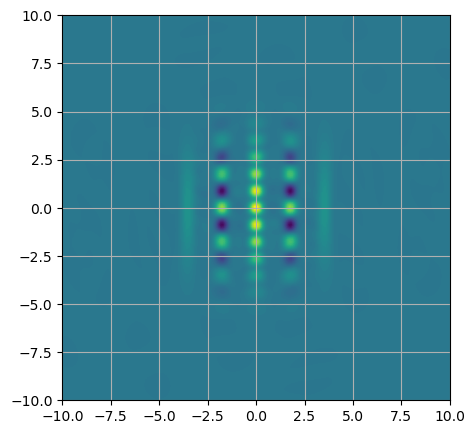

In [138]:
#Alec's optimizer [code used from GitHub repository of Alec et al.]
def rot(phi, theta):
    return (-1j*theta/2*(np.cos(phi)*tensor(sigmax(),qeye(Ncav))+np.sin(phi)*tensor(sigmay(),qeye(Ncav)))).expm()
def qub_rot(phi, theta):
    return (-1j*theta/2*(np.cos(phi)*sigmax()+np.sin(phi)*sigmay())).expm()
def R(phi, theta, N_cav):
    sx = tensor(sigmax(), identity(N_cav))
    sy = tensor(sigmay(), identity(N_cav))
    id = tensor(identity(2), identity(N_cav))
    return np.cos(theta / 2.0) * id - 1j * (
        np.cos(phi) * sx + np.sin(phi) * sy
    ) * np.sin(theta / 2.0)

#Alec's ECD with sx
def ECD2(beta, N_cav):
    if np.abs(beta) == 0:
        return tensor(qeye(2), qeye(N_cav))
    sx = tensor(sigmax(), qeye(N_cav))
    sz = tensor(sigmaz(), qeye(N_cav))
    Opa = tensor(qeye(2), destroy(N_cav))
    return sx *((beta * Opa.dag() - np.conj(beta) * Opa) * (sz / 2.0)).expm()
def U_block_ECD(beta, phi, theta, N_cav):
    return ECD2(beta, N_cav) * R(phi, theta, N_cav)

def U_circuit_ECD(betas, phis, thetas, Ncav):
    U = tensor(identity(2), identity(Ncav))
    for beta, phi, theta in zip(betas, phis, thetas):
        U = U_block_ECD(beta, phi, theta, Ncav) * U
    return U

betas= [-2.6382792e-01+1.8443625e+00j, -5.0609738e-01+8.6941522e-01j,
 -1.3805865e+00-3.7645575e-01j,  2.5752213e+00+9.4614542e-01j,
 -1.5947972e-01-3.2464623e-01j, -5.8037400e-02+1.9739866e+00j,
  2.7303159e-01-1.1620376e+00j, -6.0785359e-01+2.3638756e+00j,
 -1.9131708e-01-5.5688761e-02j, -7.3992478e-06+4.9504994e-05j]
phis= [ 0.0000000e+00,  1.5708030e+00, -1.5708077e+00, -1.5708636e+00,
 -1.5708264e+00,  1.5707130e+00, -1.5707968e+00,  1.5707079e+00,
 -1.5707320e+00, -4.6289497e-05]
thetas=[ 1.5707824,  -0.94528544,  2.242129,   -1.8487303,   2.3272734,  -1.1924248,
  2.0623205,   2.4493968,   1.6041665,   4.7123394 ]

Alec_List=[]
time_alec=[]
for i in range(len(betas)):
    Alec_List.append((U_circuit_ECD(betas[:i], phis[:i], thetas[:i], Ncav)*tensor(g,basis(Ncav,0))).ptrace(1).unit())
    time_alec.append(np.sum(np.abs(betas[:i])))

extent = 10
xvec = np.linspace(-extent,extent,200)
W = wigner(Alec_List[-1],xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X,Y,W,100)
ax.grid(True)
plt.show()


In [139]:
data0=dat(state0_List,opExpectList)#this should be extracted for Ncav=100 since SBS shows some anomaly for Ncav=400
data_log=dat(log_List,opExpectList)
data_alec=dat(Alec_List,opExpectList)

np.savez("Paper_Data/state_sbs_400.npz",state0_List)
np.savez("Paper_Data/state_alec_400.npz",Alec_List)
np.savez("Paper_Data/state_gcr_400.npz",log_List)
np.savez("Paper_Data/data_sbs_400.npz",data0)
np.savez("Paper_Data/data_alec_400.npz",data_alec)
np.savez("Paper_Data/data_gcr_400.npz",data_log)
np.savez("Paper_Data/time_sbs_400.npz",time_sbs)
np.savez("Paper_Data/time_gcr_400.npz",time_gcr)
np.savez("Paper_Data/time_alec_400.npz",time_alec)

/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_50448/2302929115.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c1=1/np.trapz(np.array(psi1),eigenvals)
/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_50448/2302929115.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c3=1/np.trapz(np.array(psi3),eigenvals)
/var/folders/k1/xhhmv5bx629_dx3jv43kpn_80000gr/T/ipykernel_50448/2302929115.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  c4=1/np.trapz(np.array(psi4),eigenvals1)


ValueError: X and Y must be the same size, but X.size is 399 and Y.size is 99.

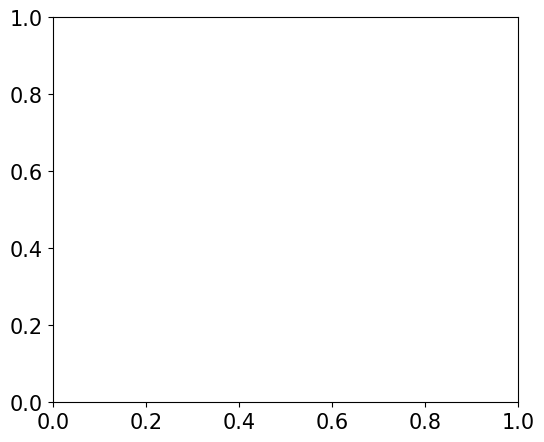

In [140]:
#check the wave function (GKP) and spin polarization (ancilla qubit) picture of the final state
eigenvals,eigenstat=xOp.eigenstates()
eigenvals1,eigenstat1=pOp.eigenstates()
axis_x=[]
psi=[]
axis_p=[]
psi1=[]
psi2=[]
psi3=[]
psi4=[]
sx=[]
sy=[]
sz=[]
ang=[]
trac=[]
a1=alpha
#State=ket2dm(log_finite)
State=log_finite1
for i in range(len(eigenstat)):
    Op1=tensor(ket2dm(eigenstat[i]),qeye(2))
    new_State=Op1*State*Op1.dag()
    mod_Qubit=new_State.ptrace(1).unit()
    mod_State=new_State.ptrace(0).unit()
    axis_x.append(eigenvals[i])
    axis_p.append(eigenvals1[i])
    psi1.append(expect(ket2dm(eigenstat[i]),(State.ptrace(0))))
    psi2.append(expect(ket2dm(eigenstat[i]),(state0)))
    psi3.append(expect(ket2dm(eigenstat[i]),(state_30)))
    psi4.append(expect(ket2dm(eigenstat[i]),(state_40)))
    sx.append(expect(sigmax(),mod_Qubit))
    sy.append(expect(sigmay(),mod_Qubit))
    sz.append(expect(sigmaz(),mod_Qubit))
    
c1=1/np.trapz(np.array(psi1),eigenvals)
#c1=1/np.sum(np.array(psi1))
psi1=np.array(psi1)*c1 
#c2=1/np.trapz(np.array(psi2),eigenvals1)
#c2=1/np.sum(np.array(psi2))
#psi2=c2*np.array(psi2) 
c3=1/np.trapz(np.array(psi3),eigenvals)
#c3=1/np.sum(np.array(psi3))
psi3=c3*np.array(psi3) 
c4=1/np.trapz(np.array(psi4),eigenvals1)
#c4=1/np.sum(np.array(psi4))
psi4=c4*np.array(psi4)   
plt.figure(figsize=(6,5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.quiver(np.real(axis_x[0:-1]),[0]*99,np.real(sx[0:-1]),np.real(sz[0:-1]),label="xy-plane")
plt.plot(axis_x,psi2,color="blue",label=r"$|\psi(p)|^2$")
plt.plot(axis_x,psi1,color="black",label=r"$|\psi(x)|^2$")
plt.plot(axis_x,psi4,color="red",label="Binomial definition")
plt.plot(axis_x,psi3,color="orange",label="Gaussian definition")
plt.plot(axis_x,sz,color="darkorange",label=r"$\langle\sigma_z\rangle$")#gives expectation of sigmaz
plt.plot(axis_x,sx,color="forestgreen",label=r"$\langle\sigma_x\rangle$")#gives expectation of sigma x
plt.plot(axis_x,sy,color="firebrick",label=r"$\langle\sigma_y\rangle$")#gives expectation of sigma y
plt.legend(loc='lower left',prop={'size': 10},frameon=False)
plt.xlim(-6,6)
plt.ylim(-1.1,1.1)
plt.xticks(np.arange(-6, 2,6))
plt.yticks(np.arange(-1,1.1,0.5))

state=log0_finite1.ptrace(0)
extent = 20
xvec = np.linspace(-extent,extent,200)
W = wigner(state_0,xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X,Y,W,100)
ax.grid(True)
plt.show()

Noisy GKP preparation for Sec. V A

In [40]:
#GKP prep with errors
kt1=1/200#transmon decay
kt2=1/200#transmon dephasing
kt3=1/1000# photon loss
cOpList=[np.sqrt(kt1)*tensor(qeye(Ncav),destroy(2)),np.sqrt(kt2)*tensor(qeye(Ncav),sigmaz()),np.sqrt(kt3)*tensor(destroy(Ncav),qeye(2))]
Delta=0.34
alpha=np.sqrt(np.pi/2)
r=-np.log(Delta)
state=ket2dm(squeeze(Ncav,r)*basis(Ncav,0))
N1=int(0.32/Delta**2)
if np.mod(N1,2)==0:
    N1=N1+1
state_40=ket2dm(logical1(1,Delta,N1,Ncav))#state0
state40=tensor(state_40,ket2dm(g))
Opx=tensor(pOp,sigmax())
Opy=tensor(-xOp,sigmay())
Opx1=tensor(pOp,sigmax()) 
log_finite1=tensor(state,ket2dm(g))
i=0
prob=1
while i<N1:
    log_finite1=mesolve(Opx,log_finite1,[0,2*alpha],c_ops=cOpList,options=Options(nsteps=5000)).states[-1]
    log_finite1=mesolve(Opy,log_finite1,[0,np.pi/4/(i+1)/alpha],c_ops=cOpList,options=Options(nsteps=5000)).states[-1]
    if i>=2:
        log_finite1=mesolve(Opx1,log_finite1,tlist=[0,angle(np.pi/4/(i+1),i+1)/alpha*Delta**2],c_ops=cOpList,options=Options(nsteps=5000)).states[-1]        
    else:
        log_finite1=mesolve(Opx1,log_finite1,tlist=[0,np.pi/4/(i+1)/alpha*Delta**2],c_ops=cOpList,options=Options(nsteps=5000)).states[-1]        
    #post-select
    prob=prob*expect(meas_g,log_finite1)
    log_finite1=meas_g*log_finite1*meas_g#post-selected state upon success
    i=i+1
fid=fidelity(state40,log_finite1)
    
print("success probability",prob)
print("success fidelity",fid)
print("We have verified these calculations by running this prep circuit for N=10^5 trials and averaging the fidelities and success probabilities over all trials (code in the cell below).")
print("Upon getting the same answers as this cell we deem this exercise time-consuming and unnecessary")

success probability 0.935112152493236
success fidelity 0.9565151710585195
We have verified these calculations by running this prep circuit for N=10^5 trials and averaging the fidelities and success probabilities over all trials (code in the cell below).
Upon getting the same answers as this cell we deem this exercise time-consuming and unnecessary


In [ ]:
#GKP prep with errors (with multiple rounds like in actual experiments): takes very long so comment this out and run it on cluster
'''
kt1=1/200#transmon decay
kt2=1/200#transmon dephasing
kt3=1/1000# photon loss
cOpList=[np.sqrt(kt1)*tensor(qeye(Ncav),destroy(2)),np.sqrt(kt2)*tensor(qeye(Ncav),sigmaz()),np.sqrt(kt3)*tensor(destroy(Ncav),qeye(2))]
Delta=0.34
alpha=np.sqrt(np.pi/2)
r=-np.log(Delta)
meas_g=tensor(qeye(Ncav),ket2dm(g))
state=ket2dm(squeeze(Ncav,r)*basis(Ncav,0))
N1=int(0.32/Delta**2)
if np.mod(N1,2)==0:
    N1=N1+1
state_40=ket2dm(logical1(1,Delta,N1,Ncav))#state0
state40=tensor(state_40,ket2dm(g))
Opx=tensor(pOp,sigmax())
Opy=tensor(-xOp,sigmay())
Opx1=tensor(pOp,sigmax()) 
succ=0
fid=0
N=100000
not_fail=1
j=0
while j<N:
    log_finite1=tensor(state,ket2dm(g))
    i=0
    while i<N1:
        log_finite1=mesolve(Opx,log_finite1,[0,2*alpha],c_ops=cOpList,options=Options(nsteps=5000)).states[-1]
        log_finite1=mesolve(Opy,log_finite1,[0,np.pi/4/(i+1)/alpha],c_ops=cOpList,options=Options(nsteps=5000)).states[-1]
        if i>=2:
            log_finite1=mesolve(Opx1,log_finite1,tlist=[0,angle(np.pi/4/(i+1),i+1)/alpha*Delta**2],c_ops=cOpList,options=Options(nsteps=5000)).states[-1]        
        else:
            log_finite1=mesolve(Opx1,log_finite1,tlist=[0,np.pi/4/(i+1)/alpha*Delta**2],c_ops=cOpList,options=Options(nsteps=5000)).states[-1]        
        #post-select
        prob=expect(meas_g,log_finite1)
        m=np.random.choice([0,1], p=[prob,1-prob])
        #print(prob,m,i,j)
        if m==1:
            succ_m=0
            i=N1
            log_finite1=tensor(state,ket2dm(g))
        else:
            log_finite1=meas_g*log_finite1*meas_g 
            succ_m=1
            i=i+1
    j=j+1
    if np.mod(j,1000)==0:
        print(succ,j,fid)
    succ=succ+succ_m
    if succ_m!=0:
        fid=fid+fidelity(state40,log_finite1)
#print("failure probability",1-not_fail)
print("success probability",succ/N)
print("average success fidelity",fid/succ)
'''

Code for Fig. 8 [Fock-state prep] is given in Paper_Figures_NA-QSP.ipynb


Fig. 10 [GKP Readout]


In [49]:
#These simulations were done in the units of the paper with Ncav=100
Ncav = 400
aOp = destroy(Ncav)
aOp1=aOp.dag()
i=np.sqrt(2)
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i
meas_px=tensor(ket2dm(px),qeye(Ncav))
meas_mx=tensor(ket2dm(mx),qeye(Ncav))
meas_g=tensor(ket2dm(g),qeye(Ncav))
meas_e=tensor(ket2dm(e),qeye(Ncav))

In [70]:

##adjoint BB1(90) protocol generalization to accommodate Gaussian functions:
#This is the correct sequence for readout
def sigma(phi):#only xy plane
    return np.cos(phi)*sigmax()+np.sin(phi)*sigmay()
def sigma_xyz(theta,phi):#whole bloch sphere
    return (np.cos(theta)*sigmaz()+np.sin(theta)*sigma(phi))
def rot_xy(theta,phi):
    return (-1j*theta/2*(np.cos(phi)*sigmax()+np.sin(phi)*sigmay())).expm()
def vec_f(vec_i,rot):#qubit vector
    return rot*vec_i*rot.dag()

Delta=0.34#0.8 gives best results
targetState0 = logical(0,Delta,Ncav)
r=-np.log(Delta)
N=200
a=-np.sqrt(np.pi)/2
alph=np.linspace(-3.9103180666759307,3.11298416936706,200)*2
theta=np.pi/2
phi0=0
phi1=np.arccos(-theta/(4*np.pi))
ep=Delta**2
x=np.pi/theta
beta=(theta/2/(np.sqrt(np.pi)/2))

perfect_GCR_BB1=GCR_BB1(targetState0)
back_x=expect(xOp,perfect_GCR_BB1.ptrace(0))/np.sqrt(2)
back_p=expect(pOp,perfect_GCR_BB1.ptrace(0))/np.sqrt(2)
corr_GCR_BB1=+1j*(back_p+np.sqrt(np.pi/2)/2)-back_x
D_GCR_BB1=displace(Ncav,corr_GCR_BB1)
        
perfect_BB1=BB1(targetState0)
back_x=expect(xOp,perfect_BB1.ptrace(0))/np.sqrt(2)
back_p=expect(pOp,perfect_BB1.ptrace(0))/np.sqrt(2)
corr_BB1=+1j*(back_p+np.sqrt(np.pi/2)/2)-back_x
D_BB1=displace(Ncav,corr_BB1)
    
sy=[]
sfid=[]
sfid1=[]
sy1=[]
for alpha1 in alph:
    initial=(displace(Ncav,alpha1/np.sqrt(2))*targetState0).unit()
    state=GCR_BB1(initial)
    sy.append(np.abs(expect(ket2dm(py),state.ptrace(1))))
    final_state=D_GCR_BB1*state.ptrace(0)*D_GCR_BB1.dag()
    sfid.append(fidelity(ket2dm(initial),final_state))

    state=BB1(initial)
    sy1.append(np.abs(expect(ket2dm(py),state.ptrace(1))))
    final_state=D_BB1*state.ptrace(0)*D_BB1.dag()
    sfid1.append(fidelity(ket2dm(initial),final_state))

np.savez("Paper_Data/GCR_BB1_GKP.npz",sy)
np.savez("Paper_Data/GCR_BB1_GKP_err.npz",alph/np.sqrt(2))
np.savez("Paper_Data/GCR_BB1_GKP_fid.npz",sfid)
np.savez("Paper_Data/BB1_GKP.npz",sy1)
np.savez("Paper_Data/BB1_GKP_fid.npz",sfid1)

In [71]:
#GCR-BB1
sy1=[]
sfid1=[]
def GCRBB1(initial):
    state=tensor(initial,g)

    Op1=tensor(1j*(beta*ep/4)*(pOp),sigmay()).expm()
    state=(Op1*state).unit()
    
    vecf=vec_f(sigma_xyz(0,0),rot_xy(0,0))
    vec=1j*sigma(phi0)*vecf
    Op1=tensor(1j*beta*(xOp),sigma(phi0)).expm()
    state=(Op1*state).unit()
    
    vecf=vec_f(vecf,rot_xy(np.pi/2,phi0))#theta-1,phi-1
    vec=1j*sigma(phi1)*vecf
    Op2=tensor(1j*np.sqrt(np.pi)*(xOp),sigma(phi1)).expm()
    state=(Op2*state).unit()
    
    vecf=vec_f(vecf,rot_xy(2*np.pi,phi1))#theta-1,phi-1
    vec=1j*sigma(3*phi1)*vecf
    Op3=tensor(2j*np.sqrt(np.pi)*(xOp),sigma(3*phi1)).expm()
    state=(Op3*state).unit()
    
    vecf=vec_f(vecf,rot_xy(4*np.pi,3*phi1))#theta-1,phi-1
    vec=-1j*sigma(phi1)*vecf
    Op4=tensor(1j*np.sqrt(np.pi)*(xOp),sigma(phi1)).expm()
    state=(Op4*state).unit()
    return state

perfect_GCRBB1=GCRBB1(targetState0)
back_x=expect(xOp,perfect_GCRBB1.ptrace(0))/np.sqrt(2)
back_p=expect(pOp,perfect_GCRBB1.ptrace(0))/np.sqrt(2)
corr_GCRBB1=+1j*(back_p+np.sqrt(np.pi/2)/2)-back_x
D_GCRBB1=displace(Ncav,corr_GCRBB1)
    
for alpha1 in alph:
    initial=(displace(Ncav,alpha1/np.sqrt(2))*targetState0).unit()
    state=GCRBB1(initial)
    sy1.append(np.abs(expect(ket2dm(py),state.ptrace(1))))
    final_state=D_GCRBB1*state.ptrace(0)*D_GCRBB1.dag()
    sfid1.append(fidelity(ket2dm(initial),final_state))
np.savez("Paper_Data/GCRBB1_GKP.npz",sy1)
np.savez("Paper_Data/GCRBB1_GKP_fid.npz",sfid1)

In [72]:
#finite-energy
sy1=[]
sfid1=[]
def GCR(initial):
    state=tensor(initial,g)

    Op1=tensor(1j*(beta*ep)*(pOp),sigmay()).expm()
    state=(Op1*state).unit()
    
    vecf=vec_f(sigma_xyz(0,0),rot_xy(0,0))
    vec=1j*sigma(phi0)*vecf
    Op1=tensor(1j*beta*(xOp),sigma(phi0)).expm()
    state=(Op1*state).unit()
    return state
perfect_GCR=GCR(targetState0)
back_x=expect(xOp,perfect_GCR.ptrace(0))/np.sqrt(2)
back_p=expect(pOp,perfect_GCR.ptrace(0))/np.sqrt(2)
corr_GCR=+1j*(back_p+np.sqrt(np.pi/2)/2)-back_x
D_GCR=displace(Ncav,corr_GCR)

for alpha1 in alph:
    initial=(displace(Ncav,alpha1/np.sqrt(2))*targetState0).unit()
    state=GCR(initial)
    sy1.append(np.abs(expect(ket2dm(py),state.ptrace(1))))
    final_state=D_GCR*state.ptrace(0)*D_GCR.dag()
    sfid1.append(fidelity(ket2dm(initial),final_state))
np.savez("Paper_Data/finite_GKP.npz",sy1)
np.savez("Paper_Data/finite_GKP_fid.npz",sfid1)

In [73]:
#ideal or infinite-energy GKP
sy1=[]
sfid1=[]
def infinite(initial):
    state=tensor(initial,g)
    vecf=vec_f(sigma_xyz(0,0),rot_xy(0,0))
    vec=1j*sigma(phi0)*vecf
    Op1=tensor(1j*beta*(xOp),sigma(phi0)).expm()
    state=(Op1*state).unit()
    return state

perfect_infinite=infinite(targetState0)
back_x=expect(xOp,perfect_infinite.ptrace(0))/np.sqrt(2)
back_p=expect(pOp,perfect_infinite.ptrace(0))/np.sqrt(2)
corr_infinite=+1j*(back_p+np.sqrt(np.pi/2)/2)-back_x
D_infinite=displace(Ncav,corr_infinite)
for alpha1 in alph:
    initial=(displace(Ncav,alpha1/np.sqrt(2))*targetState0).unit()
    state=infinite(initial)
    sy1.append(np.abs(expect(ket2dm(py),state.ptrace(1))))
    final_state=D_infinite*state.ptrace(0)*D_infinite.dag()
    sfid1.append(fidelity(ket2dm(initial),final_state))
np.savez("Paper_Data/ideal_GKP.npz",sy1)
np.savez("Paper_Data/ideal_GKP_fid.npz",sfid1)

Fig. 11 [Piecewise Gate Teleportation]

In [78]:
#These simulations were done in the units of the paper with Ncav=100
Ncav = 100
aOp = destroy(Ncav)
aOp1=aOp.dag()
i=np.sqrt(2)
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i
meas_px=tensor(ket2dm(px),qeye(Ncav))
meas_mx=tensor(ket2dm(mx),qeye(Ncav))
meas_g=tensor(ket2dm(g),qeye(Ncav))
meas_e=tensor(ket2dm(e),qeye(Ncav))

Different protocols (triial, gate teleportation, etc..)

In [79]:
targetDelta=0.3
a=2*np.sqrt(np.pi)
a1=a/2
epsilon = (a1)*targetDelta**2#twice what is needed because I apply half of this in the gate!
measIndex=10
t=epsilon/a
tpi=np.pi
nOp=aOp1*aOp
U=(1j*(np.pi/2)*aOp1*aOp).expm()
U1=U.dag()   
Hamx=tensor(sigmaz(),a1*xOp)
Hamxz=tensor(sigmaz(),a1/2*xOp)
D=tensor(qeye(2),-a1/2*xOp)
Hamp=tensor(sigmaz(),-a1*pOp)
Hamx1=tensor(sigmaz(),-a1*xOp)
Hamp1=tensor(sigmaz(),a1*pOp)
Id=qeye(Ncav)
Rx=tensor(rx(np.pi/2),qeye(Ncav)) 
Rx1=Rx.dag()
Proj_p=tensor(ket2dm(px),qeye(Ncav))
Proj_m=tensor(ket2dm(mx),qeye(Ncav))
n=4
m=8
#gate_index=20
k=1 #1 implies gate and 0 implies sBs
Ham_Gate=tensor(k*(np.pi/2/n)*sigmax(),qeye(Ncav))
Ham_Gate1=tensor(-k*(np.pi/2/n)*sigmax(),qeye(Ncav))
R_Gate=tensor(rx(np.pi/n),qeye(Ncav))
R_Gate1=R_Gate.dag()    
ECR_Gate=tensor(rx(np.pi/n/m),qeye(Ncav))
ECR_Gate1=ECR_Gate.dag()
def applyMeasurement(state,measType='+Z',correctionDirection=1):
    if 'Z' in measType:
        displacePauli = displace(Ncav,1j*a/4/np.sqrt(2))
    elif 'X' in measType:
        displacePauli = displace(Ncav,a/4/np.sqrt(2))
    elif 'Y' in measType:
        displacePauli = displace(Ncav,(1+1j)*a/4/np.sqrt(2))

    displacePaulid = displacePauli.dag()

    if '+' in measType:
        M = 0.5*(displacePauli + displacePaulid)
    elif '-' in measType:
        M = 0.5*(displacePauli - displacePaulid)

    if correctionDirection ==1:
        M = displacePauli*M
    else:
        M = displacePaulid*M
    newState = M*state*M.dag()
    return newState / newState.tr()


def computeTrajCooling(schemeParams,state,task,gate_min):
    tempState = state
    #opExpectList = schemeParams['opExpectList']
    stateList=[]
    stateQubit=[]
    expectResults = np.empty((len(opExpectList),schemeParams['Mmax']+1),dtype=complex)
    Mmax=gate_min+m
    gate_max=m+gate_min
    for j,op in enumerate(opExpectList):
        expectResults[j,0] = expect(op,tempState)#record expectation values for initState

    for i in range(schemeParams['Mmax']):
        stateList.append(tempState)
        if i>=gate_min and i<gate_max:
            if task=='gate_correction1':
                tempState,tempQubit=applyGate1(tempState,ket2dm(px),i-gate_min)
            elif task=='gate_operation2':
                tempState,tempQubit=applyGate3(tempState,ket2dm(px))
            elif task=='gate_correction2' and i==gate_min:
                tempState,tempQubit=applyGate2(tempState,ket2dm(px))#bad for dephasing
            elif task=='gate_operation1'and i==gate_min:
                tempState,tempQubit=applyGate(tempState,ket2dm(px))
            elif task=='logical_Z' and i==measIndex :
                tempState,tempQubit = Prep_Z(tempState,ket2dm(px))
            else:
                tempState,tempQubit = grid(tempState,ket2dm(px),i)
        stateQubit.append(tempQubit)
        tempState1,tempQubit  = grid(U*tempState*U1,ket2dm(px),i)
        stateQubit.append(tempQubit)
        tempState=U1*tempState1*U   
        for j,op in enumerate(opExpectList):
            expectResults[j,i+1] = expect(op,tempState)
    return expectResults,stateList,stateQubit

def logical(mu,delta,Ncav = 50,normalize=True):
    psi = 0*basis(Ncav)
    for n1 in range(-10,10+1):
        for n2 in range(-20,20+1):
            psi = (psi + np.exp(-np.pi*delta**2*((2*n1+mu)**2+n2**2)/2)
                   *np.exp(-1j*np.pi*(2*n1+mu)*n2/2)
                               *coherent(Ncav,(2*n1+mu+1j*n2)*a/2/np.sqrt(2)))
    if normalize:
        psi = psi/psi.norm()
    return psi

def Prep_Z(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    #entangled
    measState=mesolve(Hamxz,measState.unit(),[0,1],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    #Hermitian displacement to logical 0
    measState=mesolve(D,measState.unit(),[0,1],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    #Final logical 0 dispalcement
    measState=mesolve(Hamp1,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx1,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState, newqubit

def applyGate2(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Ham_Gate,measState.unit(),[0,1],c_ops=[],options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState
#This is the right thing to do for GT
def applyGate(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState,[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Ham_Gate,measState.unit(),[0,1],c_ops=[],options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Hamp1,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx1,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState
#This checks if doing just GT over m pieces is actually bad!
def applyGate3(state,qubit,i,m):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState,[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    if np.mod(i,2)==0:# no error during gate operation
        measState=mesolve(Ham_Gate,measState.unit(),[0,1/m],c_ops=[],options=Options(nsteps=5000)).states[-1]
    else:
        measState=mesolve(Ham_Gate1,measState.unit(),[0,1/m],c_ops=[],options=Options(nsteps=5000)).states[-1]    
    measState=mesolve(Hamp1,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx1,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState
#this one will suffer a probability of pz before the said gate with rate=t2*time taken by the gates before
def applyGate1(state,qubit,i,m,t2):#t2 is dephaing rate
    #pz=t2*(t+1/2)#rate*time=probability
    rot_time=1/m
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState,[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    if np.mod(i,2)==0:# no error during gate operation
        measState=mesolve(Ham_Gate,measState.unit(),[0,rot_time],c_ops=[],options=Options(nsteps=5000)).states[-1]
    else:
        measState=mesolve(Ham_Gate1,measState.unit(),[0,rot_time],c_ops=[],options=Options(nsteps=5000)).states[-1]    
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState

def grid(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newqubit=measState.ptrace(0).unit()
    newState=measState.ptrace(1).unit() 
    return newState

GKP reference states to compare fidelity against, computed via Kraus map of SBS to extract target states for comparison:

Note that we do not compare directly against GKP definitions since the piecewise gate teleportation prepares GKP states using SBS protocol which is not exactly equal to the Gaussian or binomial GKP states as seen previously in Fig 6 discussions above. So, the correct thing to do is to check if the same state was prepared via SBS cooling, how close does the PECGT come!

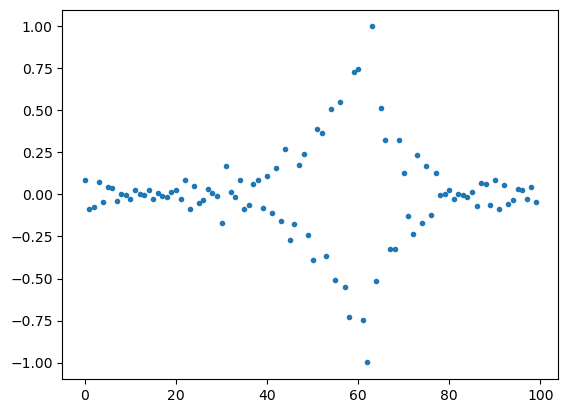

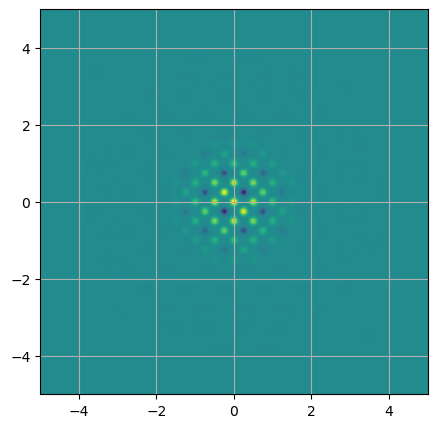

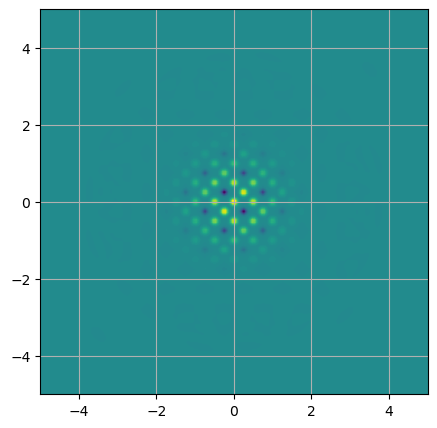

(9.214909380581155e-12+0.9892030158911083j)
(9.216339276981358e-12+0.9893170068282858j)
(-9.21649457807279e-12+0.9892269140114078j)
(-9.214753740598141e-12+0.9892931270755853j)
(0.0002669926192879757-1.2203599045511413e-15j)
0.0005338346231554825


In [80]:
targetState0 = logical(0,targetDelta,Ncav) #definition of GKP state for a given delta
targetState1 = logical(1,targetDelta,Ncav) #definition of GKP state for a given delta
xOp=(aOp+aOp1)/np.sqrt(2)
pOp=(-1j)*(aOp-aOp1)/np.sqrt(2)
eps=epsilon/2
a=2*np.sqrt(np.pi)
a1=a/2
pm=(g+1j*e).unit()
pm=(g-1j*e).unit()
s=tensor(sigmay(),(1j*eps*pOp)).expm()
s1=tensor(sigmay(),(1j*eps*pOp)).expm()
B=tensor(sigmax(),(1j*a1*xOp)).expm()
B1=tensor(sigmax(),(1j*a1/2*xOp)).expm()
B2=tensor(sigmaz(),(1j*a1/2*xOp)).expm()
D=tensor(qeye(2),(-1j*a1/2*xOp)).expm()
V=tensor(qeye(2),(1j*(np.pi/2)*nOp)).expm()#clockwise rotation of phase space, x --> -p, p --> x
V1=V.dag()   
#The gate only uses X basis or Z basis outputs
Kg_x1=(tensor(g.dag(),qeye(Ncav))*s1*B1*D*B2*B1*s*tensor(g,qeye(Ncav))).ptrace(1)
Kg_x=(tensor(g.dag(),qeye(Ncav))*s1*B*s*tensor(g,qeye(Ncav))).ptrace(1)
Ke_x=(tensor(e.dag(),qeye(Ncav))*s1*B*s*tensor(g,qeye(Ncav))).ptrace(1)
Kg_p=(tensor(g.dag(),qeye(Ncav))*V1*s1*B*s*V*tensor(g,qeye(Ncav))).ptrace(1)
Ke_p=(tensor(e.dag(),qeye(Ncav))*V1*s1*B*s*V*tensor(g,qeye(Ncav))).ptrace(1)
Kgg=(Kg_p*Kg_x)
Kge=(Kg_p*Ke_x)
Keg=(Ke_p*Kg_x)
Kee=(Ke_p*Ke_x)
eigenvals,eigenstat=Kgg.eigenstates()

#eigenvalue visualization
plt.plot(np.imag(eigenvals),'.')
max_=np.argmax(np.imag(eigenvals))
min_=np.argmin(np.imag(eigenvals))
extent = 5
xvec = np.linspace(-extent*a,extent*a,200)
W = wigner(eigenstat[max_],xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X/a,Y/a,W,100)
ax.grid(True)
plt.show()
W = wigner(Kgg*eigenstat[min_],xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X/a,Y/a,W,100)
ax.grid(True)
plt.show()

#compare analytical and SBS results

QP=(targetState0+1j*targetState1).unit()
QM=(targetState0-1j*targetState1).unit()
x=eigenstat[max_].overlap(QP)
y=eigenstat[min_].overlap(QM)
SP=(targetState0+targetState1).unit()
SM=(targetState0-targetState1).unit()
arg1=x/np.abs(x)
arg2=y/np.abs(y)
log0=(np.conjugate(x)*eigenstat[max_]-1j*np.conjugate(y)*eigenstat[min_]).unit()
log1=(np.conjugate(x)*eigenstat[max_]+1j*np.conjugate(y)*eigenstat[min_]).unit()
a2=log0.overlap(targetState0)
b2=log1.overlap(targetState1)
log00=np.conjugate(a2)*log0
log11=-np.conjugate(b2)*log1
log0=(log00+log11).unit()
log1=-(log00-log11).unit()
GP=-(log0+log1).unit()
GM=-(log0-log1).unit()
#all should be close to 1!
print(log0.overlap(targetState0))
print(log1.overlap(targetState1))
print((SP.overlap(GP)))
print((SM.overlap(GM)))

#correctness: should be close to 0
print(1-(log1.dag()*Kgg*log0))
print(1-np.abs(log0.dag()*Kgg**2*log0))

In [81]:
#reference angle using targetState
kt=0.0#cavity decay
t1=0.0#ancilla decay
t2=0.1#ancilla dephasing
n=4
log0=targetState0
log1=targetState1
GP=SP
GM=SM
ref_0=ket2dm(log0)
ref_1=ket2dm(log1)

Ham_Gate=tensor(k*(np.pi/2/n)*sigmax(),qeye(Ncav))
Ham_Gate1=tensor(-k*(np.pi/2/n)*sigmax(),qeye(Ncav))
cOpsList = [tensor(np.sqrt(t2)*sigmaz(),qeye(Ncav)),tensor(np.sqrt(t1)*destroy(2),qeye(Ncav)), tensor(qeye(2),np.sqrt(kt)*destroy(Ncav))]
def computeTrajCooling(state,task,gate_min,m,t2):
    tempState = state
    Mmax=m
    for i in range(Mmax):
        if task=='gate_correction1':
            tempState=applyGate1(tempState,ket2dm(px),i-gate_min,m,t2)
        elif task=='gate_operation1'and i==gate_min:
            tempState=applyGate(tempState,ket2dm(px))
        else:
            tempState  = grid(tempState,ket2dm(px))
        tempState1  = grid(U*tempState*U1,ket2dm(px))
        tempState=U1*tempState1*U   
    return tempState
ref_statepx=ket2dm((GP+np.exp(k*1j*np.pi/n)*GM).unit())#I
ref_statemx=ket2dm((GP-np.exp(k*1j*np.pi/n)*GM).unit())#Z
ref_statepy=ket2dm((GP+np.exp(-k*1j*np.pi/n)*GM).unit())#X
ref_statemy=ket2dm((GP-np.exp(-k*1j*np.pi/n)*GM).unit())#Y
ref_0=ket2dm(log0)
ref_1=ket2dm(log1)

In [82]:
#this is an error-free sim of the sBs states to be computed fidelity against
kt=0.0#cavity decay
t1=0.0#ancilla decay
t2=0.0#ancilla dephasing
cOpsList = [tensor(np.sqrt(t2)*sigmaz(),qeye(Ncav)),tensor(np.sqrt(t1)*destroy(2),qeye(Ncav)), tensor(qeye(2),np.sqrt(kt)*destroy(Ncav))]

Sx = displace(Ncav,1j*a/np.sqrt(2))
Sz = displace(Ncav,a/np.sqrt(2))
stabX=[]
stabP=[]

stab1X=[]
stab1P=[]

start_0=ref_0
start_1=ref_statepx
start_2=ref_statepy
start_3=ref_statemx
start_4=ref_statemy
for i in range(1,51,1):#101
    log_0= computeTrajCooling(start_0,'stabilize',i-1,1,t2)
    ref_statepx1= computeTrajCooling(start_1,'stabilize',i-1,1,t2)
    ref_statepy1= computeTrajCooling(start_2,'stabilize',i-1,1,t2)
    ref_statemx1= computeTrajCooling(start_3,'stabilize',i-1,1,t2)
    ref_statemy1= computeTrajCooling(start_4,'stabilize',i-1,1,t2)
    start_0=log_0
    start_1=ref_statepx1
    start_2=ref_statepy1
    start_3=ref_statemx1
    start_4=ref_statemy1
    stabX.append(expect(Sx,ref_statepx1))
    stabP.append(expect(Sz,ref_statepx1))

/opt/anaconda3/envs/qutip-env/lib/python3.10/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Erroneous peicewise GKP gate teleportation

In [83]:
kt=0.0#cavity decay
t1=0.0#ancilla decay
t2=0.05#ancilla dephasing
cOpsList = [tensor(np.sqrt(t2)*sigmaz(),qeye(Ncav)),tensor(np.sqrt(t1)*destroy(2),qeye(Ncav)), tensor(qeye(2),np.sqrt(kt)*destroy(Ncav))]

#state fidelity
fid2=[]
fid3=[]
fid4=[]
fid5=[]

fid0=[]
fid1=[]
fid6=[]
fid7=[]
exp_0=[]
exp_1=[]
start_0=log_0
start_1=log_0
start0=ref_statepx1 #stabilized state using SBS
start1=ref_statepy1
start2=ref_statemx1
start3=ref_statemy1
for i in range(1,51,1):
    state0= computeTrajCooling(start0,'stabilize',i-1,1,t2)
    state1= computeTrajCooling(start1,'stabilize',i-1,1,t2)
    state2= computeTrajCooling(start2,'stabilize',i-1,1,t2)
    state3= computeTrajCooling(start3,'stabilize',i-1,1,t2)
    state_0= computeTrajCooling(start_0,'gate_operation1',i-1,1,t2)
    state_1= computeTrajCooling(start_1,'gate_correction1',0,i,t2)
    if np.mod(i,2)==0:
        fid2.append(1-fidelity(state0,ref_statepx))#X_L 
    else:
        fid2.append(1-fidelity(state0,ref_statemy))# Z_L    
    if np.mod(i,2)==0:
        fid3.append(1-fidelity(state1,ref_statepy)) 
    else:
        fid3.append(1-fidelity(state1,ref_statemx))  
    if np.mod(i,2)==0:
        fid4.append(1-fidelity(state2,ref_statemx)) 
    else:
        fid4.append(1-fidelity(state2,ref_statepy))  
    if np.mod(i,2)==0:
        fid5.append(1-fidelity(state3,ref_statemy)) 
    else:
        fid5.append(1-fidelity(state3,ref_statepx))  
    if np.mod(i,2)==0:
        fid0.append(1-fidelity(state_0,ref_statemx))#X_L 
    else:
        fid0.append(1-fidelity(state_0,ref_statepy))# Z_L    
    if np.mod(i,2)==0:
        fid1.append(1-fidelity(state_1,ref_statepx)) 
    else:
        fid1.append(1-fidelity(state_1,ref_statemy))
    
    fid6.append(1-fidelity(state_0,state2))  #GT
    fid7.append(1-fidelity(state_1,state0))  #P-ECGT
    exp_0.append(1-fidelity(state_1,state3))
    exp_1.append(1-fidelity(state_0,state1))
    start_0=state_0
    start0=state0
    start1=state1
    start2=state2
    start3=state3
fid_0=(np.array(fid0[0:-1])-np.array(fid3[0:-1]))#fid 3 and fid4
fid_1=np.array(fid1[0:-1])-np.array(fid5[0:-1])#fid5 and fid 2


Toy model

In [84]:
#simulation results from qubit toy model (Fig. 6c left)
pz=0.05
px=(g+e).unit()
mx=(g-e).unit()
qub=(tensor(g,px)+tensor(e,mx)).unit()
n=4
fid_qub=[]
target=(rz(np.pi/n)*px).unit()
flip=[tensor(qeye(2),np.sqrt(pz)*sigmaz())]
b=200
l=np.linspace(1,b,b-1)
Hamz=tensor(qeye(2),(np.pi/n/2)/(1-2*pz)*sigmax())
CZ=tensor((1-sigmaz())/2,sigmaz())+tensor((1+sigmaz())/2,qeye(2))
state=ket2dm(px)
state_1=(CZ*tensor(state,ket2dm(px))*CZ.dag()).unit()
state_1=(mesolve(tensor(qeye(2),qeye(2)),state_1,[0,1],c_ops=flip,options=Options(nsteps=5000)).states[-1]).unit()
state_1=(mesolve(Hamz,state_1,[0,1],c_ops=[],options=Options(nsteps=5000)).states[-1]).unit()
state_1=(CZ*state_1*CZ.dag()).ptrace(0).unit()
target_fid=1-fidelity(state_1,ket2dm(target))
target_fid=1-(state_1*ket2dm(target)).tr()
#print(target_fid)
for m in range(1,b,1):
    state=ket2dm(px)
    target1=(rz(np.pi/n)*px).unit()
    for i in range(m):
        state=(CZ*tensor(state,ket2dm(px))*CZ.dag()).unit()
        state=(mesolve(tensor(qeye(2),qeye(2)),state,[0,1],c_ops=flip,options=Options(nsteps=5000)).states[-1]).unit()
        state=(mesolve(Hamz,state,[0,1/m],c_ops=[],options=Options(nsteps=5000)).states[-1]).unit()
        state=(CZ*state*CZ.dag()).ptrace(0).unit()
    #fid_qub.append(1-fidelity(state,ket2dm(target1)))
    fid_qub.append(1-(state*ket2dm(target1)).tr())    


#analytical results from qubit toy model (Fig. 6c left)
def calc(m,n):
    c=0
    for i in range(m+1):
        c=c+sp.special.comb(m,i)*((1-pz)**(m-i))*(pz**i)*np.cos(np.pi/n/(1-2*pz)*(pz-i/m))**2#here we put \theta/2
    return c
l1=len(fid_qub)+1
l=np.linspace(1,l1,l1-1)
calc_fid=[1-calc(i,n) for i in range(1,l1,1)]


In [85]:
np.savez("Paper_Data/GT.npz",fid_0)
np.savez("Paper_Data/P_ECGT.npz",fid_1)
np.savez("Paper_Data/analytical.npz",calc_fid)
np.savez("Paper_Data/simulation.npz",fid_qub)
np.savez("Paper_Data/trivial.npz",[target_fid]*20)


Calculations for caption of Fig. 12 [GKP CNOT]

In [23]:
Ncav = 40 #increasing this would make the simulations more accurate but way more slow
aOp = destroy(Ncav)
aOp1=aOp.dag()
nOp=aOp1*aOp
xOp=(aOp+aOp1)/np.sqrt(2)
pOp=(-1j)*(aOp-aOp1)/np.sqrt(2)
meas_px=tensor(ket2dm(px),qeye(Ncav))
meas_mx=tensor(ket2dm(mx),qeye(Ncav))


In [24]:
targetDelta=0.34
a=2*np.sqrt(np.pi)
a1=a/2
epsilon=a1*targetDelta**2
t=epsilon/a
measIndex=10
tpi=np.pi
U=(1j*(np.pi/2)*aOp1*aOp).expm()
U1=U.dag()   
Hamx=tensor(sigmaz(),a1*xOp)
Hamxz=tensor(sigmaz(),a1/2*xOp)
D=tensor(qeye(2),-a1/2*xOp)
Hamp=tensor(sigmaz(),-a1*pOp)
Hamx1=tensor(sigmaz(),-a1*xOp)
Hamp1=tensor(sigmaz(),a1*pOp)
Id=qeye(Ncav)
Rx=tensor(rx(np.pi/2),qeye(Ncav)) 
Rx1=Rx.dag()
Proj_p=tensor(ket2dm(px),qeye(Ncav))
Proj_m=tensor(ket2dm(mx),qeye(Ncav))
n=4
m=8
#gate_index=20
k=1 #1 implies gate and 0 implies sBs
Ham_Gate=tensor(k*(np.pi/2/n)*sigmax(),qeye(Ncav))
Ham_Gate1=tensor(-k*(np.pi/2/n)*sigmax(),qeye(Ncav))
R_Gate=tensor(rx(np.pi/n),qeye(Ncav))
R_Gate1=R_Gate.dag()    
ECR_Gate=tensor(rx(np.pi/n/m),qeye(Ncav))
ECR_Gate1=ECR_Gate.dag()
def applyMeasurement(state,measType='+Z',correctionDirection=1):
    if 'Z' in measType:
        displacePauli = displace(Ncav,1j*a/4/np.sqrt(2))
    elif 'X' in measType:
        displacePauli = displace(Ncav,a/4/np.sqrt(2))
    elif 'Y' in measType:
        displacePauli = displace(Ncav,(1+1j)*a/4/np.sqrt(2))

    displacePaulid = displacePauli.dag()

    if '+' in measType:
        M = 0.5*(displacePauli + displacePaulid)
    elif '-' in measType:
        M = 0.5*(displacePauli - displacePaulid)

    if correctionDirection ==1:
        M = displacePauli*M
    else:
        M = displacePaulid*M
    newState = M*state*M.dag()
    return newState / newState.tr()


def computeTrajCooling(schemeParams,state,task,gate_min):
    tempState = state
    #opExpectList = schemeParams['opExpectList']
    stateList=[]
    stateQubit=[]
    expectResults = np.empty((len(opExpectList),schemeParams['Mmax']+1),dtype=complex)
    Mmax=gate_min+m
    gate_max=m+gate_min
    for j,op in enumerate(opExpectList):
        expectResults[j,0] = expect(op,tempState)#record expectation values for initState

    for i in range(schemeParams['Mmax']):
        stateList.append(tempState)
        if i>=gate_min and i<gate_max:
            if task=='gate_correction1':
                tempState,tempQubit=applyGate1(tempState,ket2dm(px),i-gate_min)
            elif task=='gate_operation2':
                tempState,tempQubit=applyGate3(tempState,ket2dm(px))
            elif task=='gate_correction2' and i==gate_min:
                tempState,tempQubit=applyGate2(tempState,ket2dm(px))#bad for dephasing
            elif task=='gate_operation1'and i==gate_min:
                tempState,tempQubit=applyGate(tempState,ket2dm(px))
            elif task=='logical_Z' and i==measIndex :
                tempState,tempQubit = Prep_Z(tempState,ket2dm(px))
            else:
                tempState,tempQubit = grid(tempState,ket2dm(px),i)
        stateQubit.append(tempQubit)
        tempState1,tempQubit  = grid(U*tempState*U1,ket2dm(px),i)
        stateQubit.append(tempQubit)
        tempState=U1*tempState1*U   
        for j,op in enumerate(opExpectList):
            expectResults[j,i+1] = expect(op,tempState)
    return expectResults,stateList,stateQubit

def logical(mu,delta,Ncav = 50,normalize=True):
    psi = 0*basis(Ncav)
    for n1 in range(-10,10+1):
        for n2 in range(-20,20+1):
            psi = (psi + np.exp(-np.pi*delta**2*((2*n1+mu)**2+n2**2)/2)
                   *np.exp(-1j*np.pi*(2*n1+mu)*n2/2)
                               *coherent(Ncav,(2*n1+mu+1j*n2)*a/2/np.sqrt(2)))
    if normalize:
        psi = psi/psi.norm()
    return psi

def Prep_Z(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    #entangled
    measState=mesolve(Hamxz,measState.unit(),[0,1],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    #Hermitian displacement to logical 0
    measState=mesolve(D,measState.unit(),[0,1],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    #Final logical 0 dispalcement
    measState=mesolve(Hamp1,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx1,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState, newqubit

def applyGate2(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Ham_Gate,measState.unit(),[0,1],c_ops=[],options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState
#This is the right thing to do for GT
def applyGate(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState,[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Ham_Gate,measState.unit(),[0,1],c_ops=[],options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Hamp1,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx1,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState
#This checks if doing just GT over m pieces is actually bad!
def applyGate3(state,qubit,i,m):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState,[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    if np.mod(i,2)==0:# no error during gate operation
        measState=mesolve(Ham_Gate,measState.unit(),[0,1/m],c_ops=[],options=Options(nsteps=5000)).states[-1]
    else:
        measState=mesolve(Ham_Gate1,measState.unit(),[0,1/m],c_ops=[],options=Options(nsteps=5000)).states[-1]    
    measState=mesolve(Hamp1,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx1,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState
#this one will suffer a probability of pz before the said gate with rate=t2*time taken by the gates before
def applyGate1(state,qubit,i,m,t2):#t2 is dephaing rate
    #pz=t2*(t+1/2)#rate*time=probability
    rot_time=1/m
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState,[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    if np.mod(i,2)==0:# no error during gate operation
        measState=mesolve(Ham_Gate,measState.unit(),[0,rot_time],c_ops=[],options=Options(nsteps=5000)).states[-1]
    else:
        measState=mesolve(Ham_Gate1,measState.unit(),[0,rot_time],c_ops=[],options=Options(nsteps=5000)).states[-1]    
    measState=mesolve(Hamp,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace(1).unit() 
    newqubit=measState.ptrace(0).unit()
    return newState

def grid(state,qubit):
    measState = tensor(qubit,state)
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx*measState.unit()*Rx1
    measState=mesolve(Hamp,measState.unit(),[0,1],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1*measState.unit()*Rx
    measState=mesolve(Hamx,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newqubit=measState.ptrace(0).unit()
    newState=measState.ptrace(1).unit() 
    return newState

In [25]:
targetState0 = logical(0,targetDelta,Ncav) #definition of GKP state for a given delta
targetState1 = logical(1,targetDelta,Ncav) #definition of GKP state for a given delta
xOp=(aOp+aOp1)/np.sqrt(2)
pOp=(-1j)*(aOp-aOp1)/np.sqrt(2)
eps=epsilon/2
a=2*np.sqrt(np.pi)
a1=a/2
pm=(g+1j*e).unit()
pm=(g-1j*e).unit()
s=tensor(sigmay(),(1j*eps*pOp)).expm()
s1=tensor(sigmay(),(1j*eps*pOp)).expm()
B=tensor(sigmax(),(1j*a1*xOp)).expm()
B1=tensor(sigmax(),(1j*a1/2*xOp)).expm()
B2=tensor(sigmaz(),(1j*a1/2*xOp)).expm()
D=tensor(qeye(2),(-1j*a1/2*xOp)).expm()
V=tensor(qeye(2),(1j*(np.pi/2)*nOp)).expm()#clockwise rotation of phase space, x --> -p, p --> x
V1=V.dag()   
#The gate only uses X basis or Z basis outputs
Kg_x1=(tensor(g.dag(),qeye(Ncav))*s1*B1*D*B2*B1*s*tensor(g,qeye(Ncav))).ptrace(1)
Kg_x=(tensor(g.dag(),qeye(Ncav))*s1*B*s*tensor(g,qeye(Ncav))).ptrace(1)
Ke_x=(tensor(e.dag(),qeye(Ncav))*s1*B*s*tensor(g,qeye(Ncav))).ptrace(1)
Kg_p=(tensor(g.dag(),qeye(Ncav))*V1*s1*B*s*V*tensor(g,qeye(Ncav))).ptrace(1)
Ke_p=(tensor(e.dag(),qeye(Ncav))*V1*s1*B*s*V*tensor(g,qeye(Ncav))).ptrace(1)
Kgg=(Kg_p*Kg_x)
Kge=(Kg_p*Ke_x)
Keg=(Ke_p*Kg_x)
Kee=(Ke_p*Ke_x)
eigenvals,eigenstat=Kgg.eigenstates()

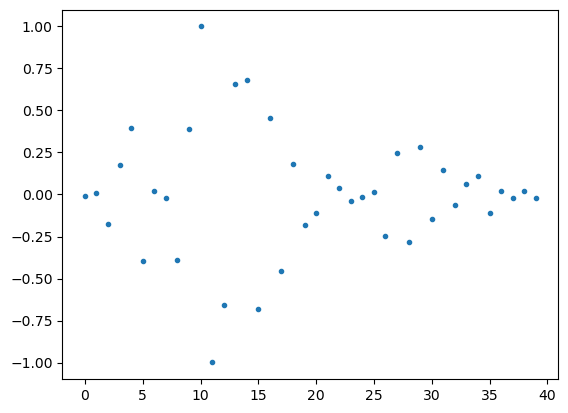

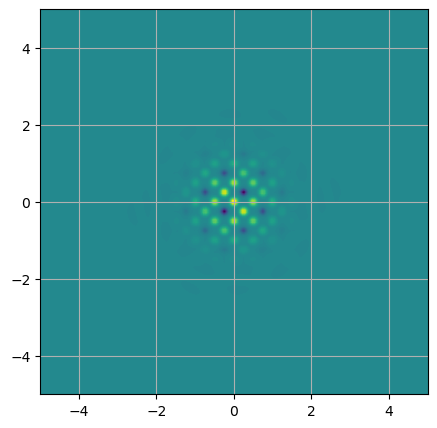

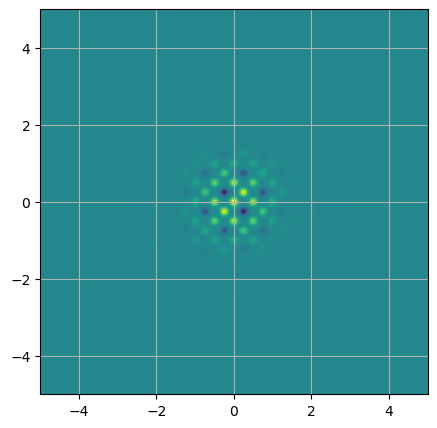

In [26]:
plt.plot(np.imag(eigenvals),'.')
max_=np.argmax(np.imag(eigenvals))
min_=np.argmin(np.imag(eigenvals))
extent = 5
xvec = np.linspace(-extent*a,extent*a,200)
W = wigner(eigenstat[max_],xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X/a,Y/a,W,100)
ax.grid(True)
plt.show()
W = wigner(Kgg*eigenstat[min_],xvec,xvec)
X,Y = np.meshgrid(xvec, xvec)
fig, ax = plt.subplots(figsize=(5,5))
ax.contourf(X/a,Y/a,W,100)
ax.grid(True)
plt.show()

In [27]:
QP=(targetState0+1j*targetState1).unit()
QM=(targetState0-1j*targetState1).unit()
x=eigenstat[max_].overlap(QP)
y=eigenstat[min_].overlap(QM)
SP=(targetState0+targetState1).unit()
SM=(targetState0-targetState1).unit()
arg1=x/np.abs(x)
arg2=y/np.abs(y)
log0=(np.conjugate(x)*eigenstat[max_]-1j*np.conjugate(y)*eigenstat[min_]).unit()
log1=(np.conjugate(x)*eigenstat[max_]+1j*np.conjugate(y)*eigenstat[min_]).unit()
a2=log0.overlap(targetState0)
b2=log1.overlap(targetState1)
log00=np.conjugate(a2)*log0
log11=-np.conjugate(b2)*log1
log0=(log00+log11).unit()
log1=-(log00-log11).unit()
GP=-(log0+log1).unit()
GM=-(log0-log1).unit()
#all should be close to 1!
print(log0.overlap(targetState0))
print(log1.overlap(targetState1))
print((SP.overlap(GP)))
print((SM.overlap(GM)))

(-2.4614808722958757e-12+0.9944605579321097j)
(-2.4640793613452524e-12+0.9951691016096899j)
(2.463134740281471e-12+0.9946932809539624j)
(2.4624249380768805e-12+0.9949367782338593j)


In [28]:
#should be close to 0
print(1-(log1.dag()*Kgg*log0))
print(1-np.abs(log0.dag()*Kgg**2*log0))

(0.0007381199217877388-4.151076641719974e-15j)
0.0013604403399846143


In [ ]:
#Run this on cluster. Takes too long! [Print statements of this cell are quoted in the caption of Fig. 12]
n=2
k=1
initial=ket2dm(tensor(log0,log0,px,px))
Hamx_a=tensor(a1*xOp,qeye(Ncav),sigmaz(),qeye(2))
Hamx_b=tensor(qeye(Ncav),a1*xOp,qeye(2),sigmaz())
Hamp_a=tensor(-a1*pOp,qeye(Ncav),sigmaz(),qeye(2))
Hamp_b=tensor(qeye(Ncav),-a1*pOp,qeye(2),sigmaz())
Rx_a=tensor(qeye(Ncav),qeye(Ncav),rx(np.pi/2),qeye(2)) 
Rx_b=tensor(qeye(Ncav),qeye(Ncav),qeye(2),rx(np.pi/2)) 
Rx1_a=Rx_a.dag()
Rx1_b=Rx_b.dag()
Ham_Gate=k*(np.pi/2/n)*tensor(qeye(Ncav),qeye(Ncav),sigmax(),sigmax())
Ham_Gate1=-k*(np.pi/2/n)*tensor(qeye(Ncav),qeye(Ncav),sigmax(),sigmax())
cOpsList=[]
def apply_XX(measState,i,m):
    rot_time=1/m
    measState=mesolve(Hamx_a,measState,[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Hamx_b,measState,[0,t],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx_a*measState.unit()*Rx1_a
    measState=Rx_b*measState.unit()*Rx1_b
    measState=mesolve(Hamp_a,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Hamp_b,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    if np.mod(i,2)==0:# no error during gate operation
        measState=mesolve(Ham_Gate,measState.unit(),[0,rot_time],c_ops=[],options=Options(nsteps=5000)).states[-1]
    else:
        measState=mesolve(Ham_Gate1,measState.unit(),[0,rot_time],c_ops=[],options=Options(nsteps=5000)).states[-1]    
    measState=mesolve(Hamp_a,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=mesolve(Hamp_b,measState.unit(),[0,1/2],c_ops=cOpsList,options=Options(nsteps=5000)).states[-1]
    measState=Rx1_a*measState.unit()*Rx_a
    measState=Rx1_b*measState.unit()*Rx_b
    measState=mesolve(Hamx_a,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    measState=mesolve(Hamx_b,measState.unit(),[0,t],c_ops=cOpsList,options=Options(nsteps=10000)).states[-1]
    newState=measState.ptrace([0,1]).unit() 
    newqubit=measState.ptrace([2,3]).unit()
    return newState,newqubit
final_state,final_qubit=apply_XX(initial,0,1)
ref=ket2dm((tensor(log0,log0)+1j*tensor(log1,log1)).unit())#Y
print(fidelity(final_state,ref))
print(expect(sigmax(),final_qubit.ptrace(1)))
print(expect(sigmax(),final_qubit.ptrace(0)))

Fig. 13 [Phase Estimation]

In [76]:
#These simulations were done in the units of the paper with Ncav=100
Ncav = 100
aOp = destroy(Ncav)
aOp1=aOp.dag()
i=np.sqrt(2)
xOp=(aOp+aOp1)/i
pOp=(-1j)*(aOp-aOp1)/i

In [77]:
def phase_est(theta,sq):
    m=1000
    targetState0=squeeze(Ncav,-sq)*coherent(Ncav,0)
    Op=tensor(qeye(Ncav),1j*theta/2*sigmaz()).expm()#leaves phase on Z state
    Disp=tensor(1j/m*xOp,sigmax()).expm()
    Op1=Disp*Op*Disp.dag()*Op.dag()
    targetState=Op1*tensor(targetState0,py)#rotate the Z eigenstate by pi/4 rotation about X to Y eigenstate
    return (expect(pOp,targetState.ptrace(0))), (variance(pOp,targetState.ptrace(0))),targetState.ptrace(1)
p=[]#mean
thet=[]
std_p=[]#variance
for i in range(0,100):
    theta=2*np.pi/100*i+(-np.pi)
    sq=0
    m=1000
    x,y,qub=phase_est(theta,sq)
    p.append(x*m)
    thet.append(theta/2)
theta=np.pi/2
for i in range(0,100):
    sq=i/100
    m=1000
    x,y,qub=phase_est(theta,sq)
    std_p.append(y)
np.savez("Paper_Data/phase_est1.npz",p)
np.savez("Paper_Data/angle1.npz",thet)
np.savez("Paper_Data/std1.npz",np.sqrt(np.abs(std_p)))